# Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import required packages
%cd drive/MyDrive/ECS289_final
#from preprocess_data import*

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import*
from tensorflow.keras.models import Sequential

!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow.keras.layers import*


# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import pandas as pd
import os
import time
import json
import collections
import operator

from glob import glob
from PIL import Image
import pickle
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import numpy as np
from tensorflow import reshape
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding, LSTM, Activation,ZeroPadding1D,Conv1D
from tqdm import tqdm


class PrepareData():
    def __init__(self):
        print('Creating an object...')
        self.PATH = 'dataset/val2014/'
        self.annotation_file = 'dataset/v2_mscoco_val2014_annotations.json'
        self.question_file = 'dataset/v2_OpenEnded_mscoco_val2014_questions.json'
        #self.all_data = os.listdir(self.PATH[:-1])
        
    # read the json file
    def parse_answers(self):
        print("Parsing answers...")
        with open(self.annotation_file, 'r') as f:
            annotations = json.load(f)

        # storing the captions and the image name in vectors
        self.all_answers = []
        self.all_answers_qids = []
        self.all_img_name_vector = []
        self.filter_list = []

        for index, annot in tqdm(enumerate(annotations['annotations'])):
            ans = annot['multiple_choice_answer']
            if ' ' not in ans and ans in ['yes', 'no']:
                caption = '<start> ' + ans + ' <end>'
                image_id = annot['image_id']
                question_id = annot['question_id']
                full_coco_image_path = self.PATH + 'COCO_val2014_' + '%012d.jpg' % (image_id)
                
                self.all_img_name_vector.append(full_coco_image_path)
                self.all_answers.append(caption)
                self.all_answers_qids.append(question_id)
            else:
                self.filter_list.append(index)
                
            
    def parse_questions(self):
        # read the json file
        print("Parsing questions...")
        with open(self.question_file, 'r') as f:
            questions = json.load(f)

        # storing the captions and the image name in vectors
        self.question_ids =[]
        self.all_questions = []
        self.all_img_name_vector_2 = []

        for index, annot in tqdm(enumerate(questions['questions'])):
            if index not in self.filter_list:
                caption = '<start> ' + annot['question'] + ' <end>'
                image_id = annot['image_id']
                full_coco_image_path = self.PATH + 'COCO_val2014_' + '%012d.jpg' % (image_id)
    
                self.all_img_name_vector_2.append(full_coco_image_path)
                self.all_questions.append(caption)
                self.question_ids.append(annot['question_id'])
        
      
    def shuffle_extract_data(self, num_examples=-1):
        print("Extracting data...")
        self.train_answers, self.train_questions, self.img_name_vector = shuffle(self.all_answers, self.all_questions,
                                              self.all_img_name_vector,
                                              random_state=1)

        # selecting the first 3000 captions from the shuffled set
        if num_examples:
            self.train_answers = self.train_answers[:num_examples]
            self.train_questions = self.train_questions[:num_examples]
            self.img_name_vector = self.img_name_vector[:num_examples]

            
    def load_image(self, image_path):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (299, 299))
        #img = tf.keras.applications.mobilenet_v3.preprocess_input(img) 
        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return img, image_path

    
    def extract_image_features(self, batch_size=64, spatial_features=True):
        
        print("Extracting image feature...")
        #image_model = tf.keras.applications.MobileNetV3Small(include_top=False, weights='imagenet')
        image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

        # Extract features from intermediate layer of image_model
        layer_index = -1
        if spatial_features:
            new_input = image_model.input
            hidden_layer = image_model.layers[layer_index].output # 
            image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
        else:
            image_features_extract_model = image_model

        # getting the unique images
        encode_train = sorted(set(self.img_name_vector))

        # feel free to change the batch_size according to your system configuration
        image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
        image_dataset = image_dataset.map(self.load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)

        for img, path in tqdm(image_dataset):
            batch_features = image_features_extract_model(img)
            # unroll image to sequence
            # batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3])) 
            # print(batch_features.shape)
            
            for bf, p in zip(batch_features, path):
                #if p not in self.all_data:
                path_of_feature = p.numpy().decode("utf-8")
                np.save(path_of_feature, bf.numpy())

                
    # This will find the maximum length of any question in our dataset
    def calc_max_length(self, tensor):
        return max(len(t) for t in tensor)


    # choosing the top 10000 words from the vocabulary, words other than top 10000 will be treated as unkown
    def create_question_vector(self, top_k_words=1000):
        print("Creating question vector...")
        self.question_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k_words,
                                                          oov_token="<unk>",
                                                          filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
        self.question_tokenizer.fit_on_texts(self.train_questions)

        self.ques_vocab = self.question_tokenizer.word_index
        self.question_tokenizer.word_index['<pad>'] = 0
        self.question_tokenizer.index_word[0] = '<pad>'

        # creating the tokenized vectors
        train_question_seqs = self.question_tokenizer.texts_to_sequences(self.train_questions)

        # padding each vector to the max_length of the captions
        # if the max_length parameter is not provided, pad_sequences calculates that automatically
        self.question_vector = tf.keras.preprocessing.sequence.pad_sequences(train_question_seqs, padding='post')

        # calculating the max_length
        # used to store the attention weights
        self.max_q = self.calc_max_length(train_question_seqs)


    def create_answer_vector(self, top_k_words=1000):
        print("Creating answer vector...")
        self.answer_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k_words,
                                                          oov_token="<unk>",
                                                          filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
        self.answer_tokenizer.fit_on_texts(self.train_answers)

        self.ans_vocab = self.answer_tokenizer.word_index
        self.answer_tokenizer.word_index['<pad>'] = 0
        self.answer_tokenizer.index_word[0] = '<pad>'

        # creating the tokenized vectors
        train_answer_seqs = self.answer_tokenizer.texts_to_sequences(self.train_answers)

        # padding each vector to the max_length of the captions
        # if the max_length parameter is not provided, pad_sequences calculates that automatically
        self.answer_vector = tf.keras.preprocessing.sequence.pad_sequences(train_answer_seqs, padding='post')

        # calculating the max_length
        # used to store the attention weights
        self.max_a = self.calc_max_length(train_answer_seqs)

        
    # loading the numpy files
    def map_func(self, img_name, cap, ans):
      img_tensor = np.load(img_name.decode('utf-8')+'.npy')
      return img_name, img_tensor, cap,ans


    def get_dataset(self, BATCH_SIZE, BUFFER_SIZE, features_shape, attention_features_shape):
        print("Creating dataset")
        img_name_train, img_name_val, question_train, question_val,answer_train, answer_val  = train_test_split(self.img_name_vector,
                                                                    self.question_vector,
                                                                    self.answer_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

        dataset = tf.data.Dataset.from_tensor_slices((img_name_train, question_train.astype(np.float32), answer_train.astype(np.float32)))

        # using map to load the numpy files in parallel
        dataset = dataset.map(lambda item1, item2, item3: tf.numpy_function(self.map_func, [item1, item2, item3], [tf.string, tf.float32, tf.float32, tf.float32]),
                  num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # shuffling and batching
        dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

        print(dataset)
        test_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, question_val.astype(np.float32), answer_val.astype(np.float32)))

        # using map to load the numpy files in parallel
        test_dataset = test_dataset.map(lambda item1, item2, item3: tf.numpy_function(
                  self.map_func, [item1, item2, item3], [tf.string, tf.float32, tf.float32, tf.float32]),
                  num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # shuffling and batching
        test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
        test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

        return dataset, test_dataset, self.ques_vocab, self.ans_vocab


/content/drive/.shortcut-targets-by-id/1P_42vUbOo7GQ_RwCNnhTMUBUYjjV6gNS/ECS289_final
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
 image_model = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
 image_model.summary()

# Modeling

In [ ]:
def get_data():
    print("In get_data")
    obj = PrepareData()
    obj.parse_answers()
    obj.parse_questions()
    obj.shuffle_extract_data(num_examples=5000)
    obj.create_question_vector()
    obj.create_answer_vector()
    #obj.extract_image_features(batch_size=64, spatial_features=False)

    resp = obj.get_dataset(128, 5000, None, None)
    print("Done getting")
    return resp, obj

In [ ]:
# import pickle 

# filehandler = open('obj_all.obj', 'wb') 
# pickle.dump(obj, filehandler)

# with open('obj_20000.obj', 'rb') as f:
#   obj_test = pickle.load(f)
  
# data_test = obj_test.get_dataset(64, 20000, None, None)
# dataset, test_dataset, ques_vocab, ans_vocab = data_test

In [ ]:
data, obj = get_data()
dataset, test_dataset, ques_vocab, ans_vocab = data
print(len(ques_vocab), len(ans_vocab))

In get_data
Creating an object...
Parsing answers...


214354it [00:00, 716589.82it/s]


Parsing questions...


214354it [04:16, 834.88it/s]


Extracting data...
Creating question vector...
Creating answer vector...
Creating dataset
<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.string, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>
Done getting
2918 6


In [ ]:
# def create_index_2_vocab(vocab_2_index):
  
#   index_2_vocab = {}
#   for key in vocab_2_index.keys():
#     value = vocab_2_index[key]
#     index_2_vocab[value] = key
  
#   return index_2_vocab

# ques_index_2_vocab = create_index_2_vocab(ques_vocab)
# len(ques_index_2_vocab)

## VQAModel_onelayer

In [ ]:
class VQAModel_onelayer_concatenation(tf.keras.Model):
  def __init__(self, ans_len, ques_len):
    super(VQAModel_onelayer_concatenation, self).__init__()
  
    self.global_ave_pooling = tf.keras.layers.GlobalAveragePooling2D()
    self.embedding = tf.keras.layers.Embedding(ques_len, 
                                               256, 
                                               batch_input_shape=[None, None], 
                                               trainable=True) 

    self.lstm1 = tf.keras.layers.LSTM(2048, return_sequences=False, return_state=False)

    self.concat1 = tf.keras.layers.Concatenate()

    self.bn1 = tf.keras.layers.BatchNormalization()
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.bn3 = tf.keras.layers.BatchNormalization()
    self.bn4 = tf.keras.layers.BatchNormalization()
    self.bn5 = tf.keras.layers.BatchNormalization()

    self.dropout1 = tf.keras.layers.Dropout(0.3)
    self.dropout2 = tf.keras.layers.Dropout(0.3)

    
    self.dense1 = tf.keras.layers.Dense(2048, activation="relu")
    self.dense1_ques = tf.keras.layers.Dense(2048, activation="relu")
    self.dense2 = tf.keras.layers.Dense(1024, activation="relu")
    self.dense3 = tf.keras.layers.Dense(256, activation="relu")

    self.dense_final = tf.keras.layers.Dense(ans_len) # , activation="softmax"

  
  def call(self, img_f, ques_f):
    # Middle fusion: fusion at one layer with concatenation
    
    img_f = self.global_ave_pooling(img_f) # batch, 2048
    img_f = self.dense1(img_f) # batch, 2048
    img_f = self.bn1(img_f) 

    #print(ques_f.shape)
    ques_f = self.embedding(ques_f)
    ques_f = self.lstm1(ques_f) # batch, 2048
    ques_f = self.dense1_ques(ques_f)
    ques_f = self.bn2(ques_f)

    fused_f = tf.concat([img_f, ques_f], axis=1) # batch, 4096

    fused_f = self.dense2(fused_f) # 1024
    fused_f = self.bn3(fused_f)
    fused_f = self.dropout1(fused_f)

    fused_f = self.dense3(fused_f) # 256
    fused_f = self.bn4(fused_f)
    fused_f = self.dropout2(fused_f)

    final_output = self.dense_final(fused_f) 
    return final_output


In [ ]:
class VQAModel_onelayer_addition(tf.keras.Model):
  def __init__(self, ans_len, ques_len):
    super(VQAModel_onelayer_addition, self).__init__()
  
    self.global_ave_pooling = tf.keras.layers.GlobalAveragePooling2D()
    self.embedding = tf.keras.layers.Embedding(ques_len, 
                                               256, 
                                               batch_input_shape=[None, None], 
                                               trainable=True) 

    self.lstm1 = tf.keras.layers.LSTM(2048, return_sequences=False, return_state=False)
    self.concat1 = tf.keras.layers.Concatenate()
    self.add = tf.keras.layers.Add()

    self.bn1 = tf.keras.layers.BatchNormalization()
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.bn3 = tf.keras.layers.BatchNormalization()
    self.bn4 = tf.keras.layers.BatchNormalization()
    self.bn5 = tf.keras.layers.BatchNormalization()

    self.relu1 = tf.keras.layers.ReLU()
    self.relu2 = tf.keras.layers.ReLU()
    self.relu3 = tf.keras.layers.ReLU()
    self.relu4 = tf.keras.layers.ReLU()
    self.relu5 = tf.keras.layers.ReLU()
    self.relu6 = tf.keras.layers.ReLU()
    self.relu7 = tf.keras.layers.ReLU()

    self.dropout1 = tf.keras.layers.Dropout(0.3)
    self.dropout2 = tf.keras.layers.Dropout(0.3)

    
    self.dense1 = tf.keras.layers.Dense(2048)
    self.dense1_ques = tf.keras.layers.Dense(2048)

    self.dense2 = tf.keras.layers.Dense(1024)
    self.dense3 = tf.keras.layers.Dense(256)

    self.dense_final = tf.keras.layers.Dense(ans_len) # , activation="softmax"

  

  def call(self, img_f, ques_f):
    # Middle fusion: fusion at one layer with concatenation
    
    img_f = self.global_ave_pooling(img_f) # batch, 2048
    img_f = self.dense1(img_f) # batch, 2048
    img_f = self.bn1(img_f)
    img_f = self.relu1(img_f) 

    ques_f = self.embedding(ques_f)
    ques_f = self.lstm1(ques_f) # batch, 2048
    ques_f = self.dense1_ques(ques_f) # batch, 2048
    ques_f = self.bn2(ques_f)
    ques_f = self.relu2(ques_f)

    fused_f = self.add([ques_f*0.5, img_f*0.5]) # batch, 2048

    fused_f = self.dense2(fused_f) # b, 1024
    fused_f = self.bn3(fused_f)
    fused_f = self.relu3(fused_f)
    fused_f = self.dropout1(fused_f)

    fused_f = self.dense3(fused_f) # b, 256
    fused_f = self.bn4(fused_f)
    fused_f = self.relu4(fused_f)
    fused_f = self.dropout2(fused_f)

    final_output = self.dense_final(fused_f) 
    return final_output

In [ ]:
class VQAModel_onelayer_dot_product(tf.keras.Model):
  def __init__(self, ans_len, ques_len):
    super(VQAModel_onelayer_dot_product, self).__init__()
  
    self.global_ave_pooling = tf.keras.layers.GlobalAveragePooling2D()
    self.embedding = tf.keras.layers.Embedding(ques_len, 
                                               256, 
                                               batch_input_shape=[None, None], 
                                               trainable=True) 

    self.lstm1 = tf.keras.layers.LSTM(2048, return_sequences=False, return_state=False)
    self.concat1 = tf.keras.layers.Concatenate()
    self.dot = tf.keras.layers.Dot(axes=1, normalize=True)

    self.bn1 = tf.keras.layers.BatchNormalization()
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.bn3 = tf.keras.layers.BatchNormalization()
    self.bn4 = tf.keras.layers.BatchNormalization()
    self.bn5 = tf.keras.layers.BatchNormalization()

    self.relu1 = tf.keras.layers.ReLU()
    self.relu2 = tf.keras.layers.ReLU()
    self.relu3 = tf.keras.layers.ReLU()
    self.relu4 = tf.keras.layers.ReLU()
    self.relu5 = tf.keras.layers.ReLU()
    self.relu6 = tf.keras.layers.ReLU()
    self.relu7 = tf.keras.layers.ReLU()

    self.dropout1 = tf.keras.layers.Dropout(0.3)
    self.dropout2 = tf.keras.layers.Dropout(0.3)

    
    self.dense1 = tf.keras.layers.Dense(2048)
    self.dense1_ques = tf.keras.layers.Dense(2048)

    self.dense2 = tf.keras.layers.Dense(1024)
    self.dense3 = tf.keras.layers.Dense(256)

    self.dense_final = tf.keras.layers.Dense(ans_len) # , activation="softmax"

  

  def call(self, img_f, ques_f):
    # Middle fusion: fusion at one layer with concatenation
    
    img_f = self.global_ave_pooling(img_f) # batch, 2048
    img_f = self.dense1(img_f) # batch, 2048
    img_f = self.bn1(img_f)
    img_f = self.relu1(img_f) 

    ques_f = self.embedding(ques_f)
    ques_f = self.lstm1(ques_f) # batch, 2048
    ques_f = self.dense1_ques(ques_f) # batch, 2048
    ques_f = self.bn2(ques_f)
    ques_f = self.relu2(ques_f)

    fused_f = self.dot([ques_f, img_f]) # batch, 1

    fused_f = self.dense2(fused_f) # b, 1024
    fused_f = self.bn3(fused_f)
    fused_f = self.relu3(fused_f)
    fused_f = self.dropout1(fused_f)

    fused_f = self.dense3(fused_f) # b, 256
    fused_f = self.bn4(fused_f)
    fused_f = self.relu4(fused_f)
    fused_f = self.dropout2(fused_f)

    final_output = self.dense_final(fused_f) 
    return final_output

In [ ]:

class VQAModel_onelayer_attention(tf.keras.Model):
  def __init__(self, ans_len, ques_len):
    super(VQAModel_onelayer_attention, self).__init__()
  
    self.global_ave_pooling = tf.keras.layers.GlobalAveragePooling2D()
    self.embedding = tf.keras.layers.Embedding(ques_len, 
                                               256, 
                                               batch_input_shape=[None, None], 
                                               trainable=True) 

    self.lstm1 = tf.keras.layers.LSTM(2048, return_sequences=True, return_state=False)
    self.lstm2= tf.keras.layers.LSTM(1024, return_sequences=True, return_state=True) #, recurrent_dropout=0.6)
    self.lstmcell = tf.keras.layers.LSTMCell(1024)

    self.concat1 = tf.keras.layers.Concatenate(axis=1)
    self.dot = tf.keras.layers.Dot(axes=1, normalize=True)
    self.reshape = tf.keras.layers.Reshape((64, 2048))

    self.bn1 = tf.keras.layers.BatchNormalization()
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.bn3 = tf.keras.layers.BatchNormalization()
    self.bn4 = tf.keras.layers.BatchNormalization()
    self.bn5 = tf.keras.layers.BatchNormalization()

    self.relu1 = tf.keras.layers.ReLU()
    self.relu2 = tf.keras.layers.ReLU()
    self.relu3 = tf.keras.layers.ReLU()
    self.relu4 = tf.keras.layers.ReLU()
    self.relu5 = tf.keras.layers.ReLU()
    self.relu6 = tf.keras.layers.ReLU()
    self.relu7 = tf.keras.layers.ReLU()

    self.dropout1 = tf.keras.layers.Dropout(0.3)
    self.dropout2 = tf.keras.layers.Dropout(0.3)

    
    self.dense1 = tf.keras.layers.Dense(2048)
    self.dense1_ques = tf.keras.layers.Dense(2048)

    self.dense2 = tf.keras.layers.Dense(1024)
    self.dense3 = tf.keras.layers.Dense(256)

    self.dense_final = tf.keras.layers.Dense(ans_len) # , activation="softmax"

  
  def call(self, img_f, ques_f):
    # Middle fusion: fusion at one layer with concatenation
    
    img_f = self.reshape(img_f)
    ques_f = self.embedding(ques_f)
    ques_f = self.lstm1(ques_f) # batch, 2048

    #print(img_f.shape, ques_f.shape)
    input_seq = self.concat1([img_f, ques_f])

   # print(input_seq.shape)

    # outputs (all hidden state of each time step), last hidden state(a), last cell state(c)
    o, h, c = self.lstm2(input_seq)

    #print(o.shape, h.shape, c.shape)
    # s0 = keras.layers.concatenate()[h, c]
    h = tf.expand_dims(h, 1)
    #c = tf.expand_dims(c, 1)

    # Query-value attention of shape [batch_size, Tq, filters].
    # query: hidden state from decoder (we use the last hidden state from encoder as first hidden state of decoder), 
    # value: all hidden state from encoder
    query_value_attention_seq = keras.layers.Attention()([h, o])
    #print(query_value_attention_seq.shape)
    query_value_attention = tf.squeeze(query_value_attention_seq, 1)
    h = tf.squeeze(h, 1)

    hidden_state, _ = self.lstmcell(query_value_attention, states=[h, c])
    #print(hidden_state.shape)

    fused_f = self.dense2(hidden_state) # b, 1024
    fused_f = self.bn3(fused_f)
    fused_f = self.relu3(fused_f)
    fused_f = self.dropout1(fused_f)

    fused_f = self.dense3(fused_f) # b, 256
    fused_f = self.bn4(fused_f)
    fused_f = self.relu4(fused_f)
    fused_f = self.dropout2(fused_f)

    final_output = self.dense_final(fused_f) 
    return final_output

In [ ]:
for (batch, (m_name, img_tensor, question, answer)) in enumerate(dataset):
    print(batch)

In [ ]:
model = VQAModel_onelayer_attention(len(ans_vocab), len(ques_vocab))
output = model(img_tensor, question)

output.shape

(128, 1024)


TensorShape([128, 6])

## VQAModel_deep

In [ ]:
class VQAModel_deep_addition(tf.keras.Model):
  def __init__(self, ans_len, ques_len):
    super(VQAModel_deep_addition, self).__init__()
  
    self.global_ave_pooling = tf.keras.layers.GlobalAveragePooling2D()
    self.embedding = tf.keras.layers.Embedding(ques_len, 
                                               256, 
                                               batch_input_shape=[None, None], 
                                               trainable=True) 

    self.lstm1 = tf.keras.layers.LSTM(2048, return_sequences=False, return_state=False)


    self.add1 = tf.keras.layers.Add()
    self.add2 = tf.keras.layers.Add()
    self.add3 = tf.keras.layers.Add()
    self.add4 = tf.keras.layers.Add()
    self.add5 = tf.keras.layers.Add()
    self.add6 = tf.keras.layers.Add()

    self.bn1 = tf.keras.layers.BatchNormalization()
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.bn3 = tf.keras.layers.BatchNormalization()
    self.bn4 = tf.keras.layers.BatchNormalization()
    self.bn5 = tf.keras.layers.BatchNormalization()
    self.bn6 = tf.keras.layers.BatchNormalization()

    self.relu1 = tf.keras.layers.ReLU()
    self.relu2 = tf.keras.layers.ReLU()
    self.relu3 = tf.keras.layers.ReLU()
    self.relu4 = tf.keras.layers.ReLU()
    self.relu5 = tf.keras.layers.ReLU()
    self.relu6 = tf.keras.layers.ReLU()


    self.dropout1 = tf.keras.layers.Dropout(0.3)
    self.dropout2 = tf.keras.layers.Dropout(0.3)
    self.dropout3 = tf.keras.layers.Dropout(0.3)
    self.dropout4 = tf.keras.layers.Dropout(0.3)

    
    self.dense1 = tf.keras.layers.Dense(2048)
    self.dense1_ques = tf.keras.layers.Dense(2048)

    self.dense2 = tf.keras.layers.Dense(1024)
    self.dense2_ques = tf.keras.layers.Dense(1024)

    self.dense3 = tf.keras.layers.Dense(256)
    self.dense3_ques = tf.keras.layers.Dense(256)

    self.dense_final = tf.keras.layers.Dense(ans_len) # , activation="softmax"


  def call(self, img_f, ques_f):
    # Middle fusion: fusion at one layer with concatenation
    
    img_f = self.global_ave_pooling(img_f) # batch, 2048
    img_f = self.dense1(img_f) # batch, 2048
    img_f = self.bn1(img_f)
    img_f = self.relu1(img_f) 

    ques_f = self.embedding(ques_f)
    ques_f = self.lstm1(ques_f) # batch, 2048
    ques_f = self.dense1_ques(ques_f) # batch, 2048
    ques_f = self.bn2(ques_f)
    ques_f = self.relu2(ques_f)

    
    fused_que = self.add1([ques_f*0.7, img_f*0.3]) # batch, 2048
    fused_img = self.add2([ques_f*0.3, img_f*0.7]) # batch, 2048

    fused_img = self.dense2(fused_img) # b, 1024
    fused_img = self.bn3(fused_img)
    fused_img= self.relu3(fused_img)
    fused_img = self.dropout1(fused_img)

    fused_que = self.dense2_ques(fused_que) # b, 1024
    fused_que = self.bn4(fused_que)
    fused_que= self.relu4(fused_que)
    fused_que = self.dropout2(fused_que)


    fused_que = self.add3([fused_que*0.7, fused_img*0.3]) # batch, 2048
    fused_img = self.add4([fused_que*0.3, fused_img*0.7]) # batch, 2048

    fused_img = self.dense3(fused_img) # b, 1024
    fused_img = self.bn5(fused_img)
    fused_img= self.relu5(fused_img)
    fused_img = self.dropout3(fused_img)

    fused_que = self.dense3_ques(fused_que) # b, 1024
    fused_que = self.bn6(fused_que)
    fused_que= self.relu6(fused_que)
    fused_que = self.dropout4(fused_que)

    fused_f = self.add5([fused_que*0.5, fused_img*0.5])

    final_output = self.dense_final(fused_f) 
    return final_output

In [ ]:
class VQAModel_deep_dot_product(tf.keras.Model):
  def __init__(self, ans_len, ques_len):
    super(VQAModel_deep_dot_product, self).__init__()
  
    self.global_ave_pooling = tf.keras.layers.GlobalAveragePooling2D()
    self.embedding = tf.keras.layers.Embedding(ques_len, 
                                               256, 
                                               batch_input_shape=[None, None], 
                                               trainable=True) 

    self.lstm1 = tf.keras.layers.LSTM(2048, return_sequences=False, return_state=False)
    #self.concat1 = tf.keras.layers.Concatenate()
    self.dot1 = tf.keras.layers.Add()
    self.add2 = tf.keras.layers.Add()
    self.add3 = tf.keras.layers.Add()
    self.add4 = tf.keras.layers.Add()
    self.add5 = tf.keras.layers.Add()
    self.add6 = tf.keras.layers.Add()

    self.dot1 = tf.keras.layers.Dot(axes=1, normalize=True)
    self.dot2 = tf.keras.layers.Dot(axes=1, normalize=True)
    self.dot3 = tf.keras.layers.Dot(axes=1, normalize=True)
    self.dot4 = tf.keras.layers.Dot(axes=1, normalize=True)
    self.dot5 = tf.keras.layers.Dot(axes=1, normalize=True)
    self.dot6 = tf.keras.layers.Dot(axes=1, normalize=True)
    self.dot7 = tf.keras.layers.Dot(axes=1, normalize=True)

    self.bn1 = tf.keras.layers.BatchNormalization()
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.bn3 = tf.keras.layers.BatchNormalization()
    self.bn4 = tf.keras.layers.BatchNormalization()
    self.bn5 = tf.keras.layers.BatchNormalization()
    self.bn6 = tf.keras.layers.BatchNormalization()

    self.relu1 = tf.keras.layers.ReLU()
    self.relu2 = tf.keras.layers.ReLU()
    self.relu3 = tf.keras.layers.ReLU()
    self.relu4 = tf.keras.layers.ReLU()
    self.relu5 = tf.keras.layers.ReLU()
    self.relu6 = tf.keras.layers.ReLU()


    self.dropout1 = tf.keras.layers.Dropout(0.3)
    self.dropout2 = tf.keras.layers.Dropout(0.3)
    self.dropout3 = tf.keras.layers.Dropout(0.3)
    self.dropout4 = tf.keras.layers.Dropout(0.3)

    
    self.dense1 = tf.keras.layers.Dense(2048)
    self.dense1_ques = tf.keras.layers.Dense(2048)

    self.dense2 = tf.keras.layers.Dense(1024)
    self.dense2_ques = tf.keras.layers.Dense(1024)

    self.dense3 = tf.keras.layers.Dense(256)
    self.dense3_ques = tf.keras.layers.Dense(256)

    self.dense_final = tf.keras.layers.Dense(ans_len) # , activation="softmax"


  def call(self, img_f, ques_f):
    # Middle fusion: fusion at one layer with concatenation
    
    img_f = self.global_ave_pooling(img_f) # batch, 2048
    img_f = self.dense1(img_f) # batch, 2048
    img_f = self.bn1(img_f)
    img_f = self.relu1(img_f) 

    ques_f = self.embedding(ques_f)
    ques_f = self.lstm1(ques_f) # batch, 2048
    ques_f = self.dense1_ques(ques_f) # batch, 2048
    ques_f = self.bn2(ques_f)
    ques_f = self.relu2(ques_f)

    
    fused_f= self.dot1([ques_f, img_f]) # batch, 1

    fused_img = self.dense2(fused_f) # b, 1024
    fused_img = self.bn3(fused_img)
    fused_img= self.relu3(fused_img)
    fused_img = self.dropout1(fused_img)

    fused_que = self.dense2_ques(fused_f) # b, 1024
    fused_que = self.bn4(fused_que)
    fused_que= self.relu4(fused_que)
    fused_que = self.dropout2(fused_que)


    fused_f= self.dot2([fused_que, fused_img]) # b, 1

    fused_img = self.dense3(fused_f) # b, 1024
    fused_img = self.bn5(fused_img)
    fused_img= self.relu5(fused_img)
    fused_img = self.dropout3(fused_img)

    fused_que = self.dense3_ques(fused_f) # b, 1024
    fused_que = self.bn6(fused_que)
    fused_que= self.relu6(fused_que)
    fused_que = self.dropout4(fused_que)

    fused_f = self.dot3([fused_que, fused_img])

    final_output = self.dense_final(fused_f) 
    return final_output

In [ ]:
class VQAModel_deep_with_attention(tf.keras.Model):
  def __init__(self, ans_len, ques_len):
    super(VQAModel_deep_with_attention, self).__init__()
  
    self.global_ave_pooling = tf.keras.layers.GlobalAveragePooling2D()
    self.embedding = tf.keras.layers.Embedding(ques_len, 
                                               256, 
                                               batch_input_shape=[None, None], 
                                               trainable=True) 

    self.lstm1 = tf.keras.layers.LSTM(2048, return_sequences=True, return_state=False)
    self.lstm2= tf.keras.layers.LSTM(1024, return_sequences=True, return_state=True) #, recurrent_dropout=0.6)
    self.lstmcell = tf.keras.layers.LSTMCell(1024)

    self.concat1 = tf.keras.layers.Concatenate(axis=1)
    self.dot = tf.keras.layers.Dot(axes=1, normalize=True)
    self.reshape = tf.keras.layers.Reshape((64, 2048))

    self.bn1 = tf.keras.layers.BatchNormalization()
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.bn3 = tf.keras.layers.BatchNormalization()
    self.bn4 = tf.keras.layers.BatchNormalization()
    self.bn5 = tf.keras.layers.BatchNormalization()

    self.relu1 = tf.keras.layers.ReLU()
    self.relu2 = tf.keras.layers.ReLU()
    self.relu3 = tf.keras.layers.ReLU()
    self.relu4 = tf.keras.layers.ReLU()
    self.relu5 = tf.keras.layers.ReLU()
    self.relu6 = tf.keras.layers.ReLU()
    self.relu7 = tf.keras.layers.ReLU()

    self.dropout1 = tf.keras.layers.Dropout(0.3)
    self.dropout2 = tf.keras.layers.Dropout(0.3)

    
    self.dense1 = tf.keras.layers.Dense(2048)
    self.dense1_ques = tf.keras.layers.Dense(2048)

    self.dense2 = tf.keras.layers.Dense(1024)
    self.dense2_ques = tf.keras.layers.Dense(1024)

    self.dense3 = tf.keras.layers.Dense(256)

    self.dense_final = tf.keras.layers.Dense(ans_len) # , activation="softmax"

  
  def call(self, img_f, ques_f):
    img_f = self.reshape(img_f)
    ques_f = self.embedding(ques_f)
    ques_f = self.lstm1(ques_f) # batch, 2048

    #print(img_f.shape, ques_f.shape)
    input_seq = self.concat1([img_f, ques_f])

   # print(input_seq.shape)

    # outputs (all hidden state of each time step), last hidden state(a), last cell state(c)
    o, h, c = self.lstm2(input_seq)

    #print(o.shape, h.shape, c.shape)
    # s0 = keras.layers.concatenate()[h, c]
    h = tf.expand_dims(h, 1)
    #c = tf.expand_dims(c, 1)

    # Query-value attention of shape [batch_size, Tq, filters].
    # query: hidden state from decoder (we use the last hidden state from encoder as first hidden state of decoder), 
    # value: all hidden state from encoder
    query_value_attention_seq = keras.layers.Attention()([h, o])
    #print(query_value_attention_seq.shape)
    query_value_attention = tf.squeeze(query_value_attention_seq, 1)
    h = tf.squeeze(h, 1)

    hidden_state, _ = self.lstmcell(query_value_attention, states=[h, c])
    #print(hidden_state.shape)

    fused_img = self.dense2(hidden_state) # b, 1024
    fused_img = self.bn3(fused_img)
    fused_img= self.relu3(fused_img)
    fused_img = self.dropout1(fused_img)

    fused_que = self.dense2_ques(hidden_state) # b, 1024
    fused_que = self.bn4(fused_que)
    fused_que= self.relu4(fused_que)
    fused_que = self.dropout2(fused_que)

    fused_f = self.concat1([fused_que, fused_img]) # b, 2048
    final_output = self.dense_final(fused_f) 
    
    return final_output

In [ ]:
model = VQAModel_deep_with_attention(len(ans_vocab), len(ques_vocab))
output = model(img_tensor, question)

(128, 2048)


In [18]:
output.shape

TensorShape([128, 6])

## VQAModel_shortcut

In [46]:
class VQAModel_shortcut_addition(tf.keras.Model):
  def __init__(self, ans_len, ques_len):
    super(VQAModel_shortcut_addition, self).__init__()
  
    self.global_ave_pooling = tf.keras.layers.GlobalAveragePooling2D()
    self.embedding = tf.keras.layers.Embedding(ques_len, 
                                               256, 
                                               batch_input_shape=[None, None], 
                                               trainable=True) 

    self.lstm1 = tf.keras.layers.LSTM(2048, return_sequences=False, return_state=False)
    self.concat1 = tf.keras.layers.Concatenate(axis=1)
    self.concat2 = tf.keras.layers.Concatenate(axis=1)
    self.concat3 = tf.keras.layers.Concatenate(axis=1)
    self.dot1 = tf.keras.layers.Add()
    
    self.add1 = tf.keras.layers.Add()
    self.add2 = tf.keras.layers.Add()
    self.add3 = tf.keras.layers.Add()
    self.add4 = tf.keras.layers.Add()
    self.add5 = tf.keras.layers.Add()
    self.add6 = tf.keras.layers.Add()

    self.bn1 = tf.keras.layers.BatchNormalization()
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.bn3 = tf.keras.layers.BatchNormalization()
    self.bn4 = tf.keras.layers.BatchNormalization()
    self.bn5 = tf.keras.layers.BatchNormalization()
    self.bn6 = tf.keras.layers.BatchNormalization()
    self.bn7 = tf.keras.layers.BatchNormalization()
    self.bn8 = tf.keras.layers.BatchNormalization()

    self.relu1 = tf.keras.layers.ReLU()
    self.relu2 = tf.keras.layers.ReLU()
    self.relu3 = tf.keras.layers.ReLU()
    self.relu4 = tf.keras.layers.ReLU()
    self.relu5 = tf.keras.layers.ReLU()
    self.relu6 = tf.keras.layers.ReLU()
    self.relu7 = tf.keras.layers.ReLU()
    self.relu8 = tf.keras.layers.ReLU()


    self.dropout1 = tf.keras.layers.Dropout(0.3)
    self.dropout2 = tf.keras.layers.Dropout(0.3)
    self.dropout3 = tf.keras.layers.Dropout(0.3)
    self.dropout4 = tf.keras.layers.Dropout(0.3)
    self.dropout5 = tf.keras.layers.Dropout(0.3)
    self.dropout6 = tf.keras.layers.Dropout(0.3)

    
    self.dense1 = tf.keras.layers.Dense(2048)
    self.dense1_ques = tf.keras.layers.Dense(2048)

    self.dense2 = tf.keras.layers.Dense(1024)
    self.dense2_ques = tf.keras.layers.Dense(1024)

    self.dense3 = tf.keras.layers.Dense(256)
    self.dense3_ques = tf.keras.layers.Dense(256)

    self.dense4 = tf.keras.layers.Dense(128)
    self.dense5 = tf.keras.layers.Dense(64)

    self.dense_final = tf.keras.layers.Dense(ans_len) # , activation="softmax"


  def call(self, img_f, ques_f):
    # Middle fusion: fusion at one layer with concatenation
    
    img_f = self.global_ave_pooling(img_f) # batch, 2048
    img_f = self.dense1(img_f) # batch, 2048
    img_f = self.bn1(img_f)
    img_f = self.relu1(img_f)

    img_f2 = self.dense2(img_f) # batch, 1024
    img_f2 = self.bn2(img_f2)
    img_f2 = self.relu2(img_f2) 
    img_f2 = self.dropout1(img_f2)

    img_f3 = self.dense3(img_f2) # batch, 256
    img_f3 = self.bn3(img_f3)
    img_f3 = self.relu3(img_f3) 
    img_f3 = self.dropout2(img_f3)


    ques_f = self.embedding(ques_f)
    ques_f = self.lstm1(ques_f) # batch, 2048
    ques_f = self.dense1_ques(ques_f) # batch, 2048
    ques_f = self.bn4(ques_f)
    ques_f = self.relu4(ques_f)

    ques_f2 = self.dense2_ques(ques_f) # batch, 1024
    ques_f2 = self.bn5(ques_f2)
    ques_f2 = self.relu5(ques_f2)
    ques_f2 = self.dropout3(ques_f2)

    ques_f3 = self.dense3_ques(ques_f2) # batch, 256
    ques_f3 = self.bn6(ques_f3)
    ques_f3 = self.relu6(ques_f3)
    ques_f2 = self.dropout4(ques_f2)

    fused_f1 = self.add1([ques_f3*0.5, img_f3*0.5]) # batch, 2048

    fused_f1= self.dense4(fused_f1) # b, 128
    fused_f1 = self.bn7(fused_f1)
    fused_f1= self.relu7(fused_f1)
    fused_f1 = self.dropout5(fused_f1)
    fused_f1  = self.concat1([fused_f1, img_f])
    fused_f1  = self.concat2([fused_f1, ques_f])

    fused_f2= self.dense5(fused_f1) # b, 64
    fused_f2 = self.bn8(fused_f2)
    fused_f2= self.relu8(fused_f2)
    fused_f2 = self.dropout6(fused_f2)
    fused_f2  = self.concat1([fused_f2, img_f2])
    fused_f2  = self.concat2([fused_f2, ques_f2])

    final_output = self.dense_final(fused_f2) 
    return final_output

In [ ]:
class VQAModel_shortcut_concatenation(tf.keras.Model):
  def __init__(self, ans_len, ques_len):
    super(VQAModel_shortcut_concatenation, self).__init__()
  
    self.global_ave_pooling = tf.keras.layers.GlobalAveragePooling2D()
    self.embedding = tf.keras.layers.Embedding(ques_len, 
                                               256, 
                                               batch_input_shape=[None, None], 
                                               trainable=True) 

    self.lstm1 = tf.keras.layers.LSTM(2048, return_sequences=False, return_state=False)
    self.concat1 = tf.keras.layers.Concatenate(axis=1)
    self.concat2 = tf.keras.layers.Concatenate(axis=1)
    self.concat3 = tf.keras.layers.Concatenate(axis=1)
    self.concat4 = tf.keras.layers.Concatenate(axis=1)
    self.concat5 = tf.keras.layers.Concatenate(axis=1)

    self.add1 = tf.keras.layers.Add()
    self.add2 = tf.keras.layers.Add()
    self.add3 = tf.keras.layers.Add()
    self.add4 = tf.keras.layers.Add()
    self.add5 = tf.keras.layers.Add()
    self.add6 = tf.keras.layers.Add()

    self.bn1 = tf.keras.layers.BatchNormalization()
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.bn3 = tf.keras.layers.BatchNormalization()
    self.bn4 = tf.keras.layers.BatchNormalization()
    self.bn5 = tf.keras.layers.BatchNormalization()
    self.bn6 = tf.keras.layers.BatchNormalization()
    self.bn7 = tf.keras.layers.BatchNormalization()
    self.bn8 = tf.keras.layers.BatchNormalization()

    self.relu1 = tf.keras.layers.ReLU()
    self.relu2 = tf.keras.layers.ReLU()
    self.relu3 = tf.keras.layers.ReLU()
    self.relu4 = tf.keras.layers.ReLU()
    self.relu5 = tf.keras.layers.ReLU()
    self.relu6 = tf.keras.layers.ReLU()
    self.relu7 = tf.keras.layers.ReLU()
    self.relu8 = tf.keras.layers.ReLU()


    self.dropout1 = tf.keras.layers.Dropout(0.3)
    self.dropout2 = tf.keras.layers.Dropout(0.3)
    self.dropout3 = tf.keras.layers.Dropout(0.3)
    self.dropout4 = tf.keras.layers.Dropout(0.3)
    self.dropout5 = tf.keras.layers.Dropout(0.3)
    self.dropout6 = tf.keras.layers.Dropout(0.3)

    
    self.dense1 = tf.keras.layers.Dense(2048)
    self.dense1_ques = tf.keras.layers.Dense(2048)

    self.dense2 = tf.keras.layers.Dense(1024)
    self.dense2_ques = tf.keras.layers.Dense(1024)

    self.dense3 = tf.keras.layers.Dense(256)
    self.dense3_ques = tf.keras.layers.Dense(256)

    self.dense4 = tf.keras.layers.Dense(128)
    self.dense5 = tf.keras.layers.Dense(64)

    self.dense_final = tf.keras.layers.Dense(ans_len) # , activation="softmax"


  def call(self, img_f, ques_f):
    # Middle fusion: fusion at one layer with concatenation
    
    img_f = self.global_ave_pooling(img_f) # batch, 2048
    img_f = self.dense1(img_f) # batch, 2048
    img_f = self.bn1(img_f)
    img_f = self.relu1(img_f)

    img_f2 = self.dense2(img_f) # batch, 1024
    img_f2 = self.bn2(img_f2)
    img_f2 = self.relu2(img_f2) 
    img_f2 = self.dropout1(img_f2)

    img_f3 = self.dense3(img_f2) # batch, 256
    img_f3 = self.bn3(img_f3)
    img_f3 = self.relu3(img_f3) 
    img_f3 = self.dropout2(img_f3)


    ques_f = self.embedding(ques_f)
    ques_f = self.lstm1(ques_f) # batch, 2048
    ques_f = self.dense1_ques(ques_f) # batch, 2048
    ques_f = self.bn4(ques_f)
    ques_f = self.relu4(ques_f)

    ques_f2 = self.dense2_ques(ques_f) # batch, 1024
    ques_f2 = self.bn5(ques_f2)
    ques_f2 = self.relu5(ques_f2)
    ques_f2 = self.dropout3(ques_f2)

    ques_f3 = self.dense3_ques(ques_f2) # batch, 256
    ques_f3 = self.bn6(ques_f3)
    ques_f3 = self.relu6(ques_f3)
    ques_f2 = self.dropout4(ques_f2)

    fused_f1 = self.concat1([ques_f3*0.5, img_f3*0.5]) # batch, 2048

    fused_f1= self.dense4(fused_f1) # b, 1024
    fused_f1 = self.bn7(fused_f1)
    fused_f1= self.relu7(fused_f1)
    fused_f1 = self.dropout5(fused_f1)
    fused_f1  = self.concat2([fused_f1, img_f])
    fused_f1  = self.concat3([fused_f1, ques_f])

    fused_f2= self.dense5(fused_f1) # b, 1024
    fused_f2 = self.bn8(fused_f2)
    fused_f2= self.relu8(fused_f2)
    fused_f2 = self.dropout6(fused_f2)
    fused_f2  = self.concat4([fused_f2, img_f2])
    fused_f2  = self.concat5([fused_f2, ques_f2])

    final_output = self.dense_final(fused_f2) 
    return final_output

In [ ]:
class VQAModel_shortcut_dotproduct(tf.keras.Model):
  def __init__(self, ans_len, ques_len):
    super(VQAModel_shortcut_dotproduct, self).__init__()
  
    self.global_ave_pooling = tf.keras.layers.GlobalAveragePooling2D()
    self.embedding = tf.keras.layers.Embedding(ques_len, 
                                               256, 
                                               batch_input_shape=[None, None], 
                                               trainable=True) 

    self.lstm1 = tf.keras.layers.LSTM(2048, return_sequences=False, return_state=False)
    self.concat1 = tf.keras.layers.Concatenate(axis=1)
    self.concat2 = tf.keras.layers.Concatenate(axis=1)
    self.concat3 = tf.keras.layers.Concatenate(axis=1)
    self.concat4 = tf.keras.layers.Concatenate(axis=1)
    self.concat5 = tf.keras.layers.Concatenate(axis=1)
    self.dot1 = tf.keras.layers.Add()

    self.add1 = tf.keras.layers.Add()
    self.add2 = tf.keras.layers.Add()
    self.add3 = tf.keras.layers.Add()
    self.add4 = tf.keras.layers.Add()
    self.add5 = tf.keras.layers.Add()
    self.add6 = tf.keras.layers.Add()

    self.bn1 = tf.keras.layers.BatchNormalization()
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.bn3 = tf.keras.layers.BatchNormalization()
    self.bn4 = tf.keras.layers.BatchNormalization()
    self.bn5 = tf.keras.layers.BatchNormalization()
    self.bn6 = tf.keras.layers.BatchNormalization()
    self.bn7 = tf.keras.layers.BatchNormalization()
    self.bn8 = tf.keras.layers.BatchNormalization()

    self.relu1 = tf.keras.layers.ReLU()
    self.relu2 = tf.keras.layers.ReLU()
    self.relu3 = tf.keras.layers.ReLU()
    self.relu4 = tf.keras.layers.ReLU()
    self.relu5 = tf.keras.layers.ReLU()
    self.relu6 = tf.keras.layers.ReLU()
    self.relu7 = tf.keras.layers.ReLU()
    self.relu8 = tf.keras.layers.ReLU()


    self.dropout1 = tf.keras.layers.Dropout(0.3)
    self.dropout2 = tf.keras.layers.Dropout(0.3)
    self.dropout3 = tf.keras.layers.Dropout(0.3)
    self.dropout4 = tf.keras.layers.Dropout(0.3)
    self.dropout5 = tf.keras.layers.Dropout(0.3)
    self.dropout6 = tf.keras.layers.Dropout(0.3)

    
    self.dense1 = tf.keras.layers.Dense(2048)
    self.dense1_ques = tf.keras.layers.Dense(2048)

    self.dense2 = tf.keras.layers.Dense(1024)
    self.dense2_ques = tf.keras.layers.Dense(1024)

    self.dense3 = tf.keras.layers.Dense(256)
    self.dense3_ques = tf.keras.layers.Dense(256)

    self.dense4 = tf.keras.layers.Dense(128)
    self.dense5 = tf.keras.layers.Dense(64)

    self.dense_final = tf.keras.layers.Dense(ans_len) # , activation="softmax"


  def call(self, img_f, ques_f):
    # Middle fusion: fusion at one layer with concatenation
    
    img_f = self.global_ave_pooling(img_f) # batch, 2048
    img_f = self.dense1(img_f) # batch, 2048
    img_f = self.bn1(img_f)
    img_f = self.relu1(img_f)

    img_f2 = self.dense2(img_f) # batch, 1024
    img_f2 = self.bn2(img_f2)
    img_f2 = self.relu2(img_f2) 
    img_f2 = self.dropout1(img_f2)

    img_f3 = self.dense3(img_f2) # batch, 256
    img_f3 = self.bn3(img_f3)
    img_f3 = self.relu3(img_f3) 
    img_f3 = self.dropout2(img_f3)


    ques_f = self.embedding(ques_f)
    ques_f = self.lstm1(ques_f) # batch, 2048
    ques_f = self.dense1_ques(ques_f) # batch, 2048
    ques_f = self.bn4(ques_f)
    ques_f = self.relu4(ques_f)

    ques_f2 = self.dense2_ques(ques_f) # batch, 1024
    ques_f2 = self.bn5(ques_f2)
    ques_f2 = self.relu5(ques_f2)
    ques_f2 = self.dropout3(ques_f2)

    ques_f3 = self.dense3_ques(ques_f2) # batch, 256
    ques_f3 = self.bn6(ques_f3)
    ques_f3 = self.relu6(ques_f3)
    ques_f2 = self.dropout4(ques_f2)

    fused_f1 = self.dot1([ques_f3, img_f3]) # batch, 1

    fused_f1= self.dense4(fused_f1) # b, 1024
    fused_f1 = self.bn7(fused_f1)
    fused_f1= self.relu7(fused_f1)
    fused_f1 = self.dropout5(fused_f1)
    fused_f1  = self.concat2([fused_f1, img_f])
    fused_f1  = self.concat3([fused_f1, ques_f])

    fused_f2= self.dense5(fused_f1) # b, 1024
    fused_f2 = self.bn8(fused_f2)
    fused_f2= self.relu8(fused_f2)
    fused_f2 = self.dropout6(fused_f2)
    fused_f2  = self.concat4([fused_f2, img_f2])
    fused_f2  = self.concat5([fused_f2, ques_f2])

    final_output = self.dense_final(fused_f2) 
    return final_output

In [42]:
class VQAModel_shortcut_with_attention(tf.keras.Model):
  def __init__(self, ans_len, ques_len):
    super(VQAModel_shortcut_with_attention, self).__init__()
  
    self.global_ave_pooling1 = tf.keras.layers.GlobalAveragePooling2D()
    self.global_ave_pooling2 = tf.keras.layers.GlobalAveragePooling2D()
    self.global_ave_pooling3 = tf.keras.layers.GlobalAveragePooling2D()

    self.embedding = tf.keras.layers.Embedding(ques_len, 
                                               256, 
                                               batch_input_shape=[None, None], 
                                               trainable=True) 

    self.lstm1 = tf.keras.layers.LSTM(2048, return_sequences=True, return_state=True)
    self.lstm2 = tf.keras.layers.LSTM(256, return_sequences=True, return_state=True) #, recurrent_dropout=0.6)

    self.lstm3 = tf.keras.layers.LSTM(1024, return_sequences=True, return_state=True, recurrent_dropout=0.3)
    self.lstm4 = tf.keras.layers.LSTM(256, return_sequences=True, return_state=True, recurrent_dropout=0.3)

    self.lstmcell = tf.keras.layers.LSTMCell(1024)

    self.con2d1 = tf.keras.layers.Conv2D(filters=1024, kernel_size=(2,2))
    self.con2d2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(2,2))


    self.concat1 = tf.keras.layers.Concatenate(axis=1)
    self.concat2 = tf.keras.layers.Concatenate(axis=1)
    self.concat3 = tf.keras.layers.Concatenate(axis=1)
    self.concat4 = tf.keras.layers.Concatenate(axis=1)
    self.concat5 = tf.keras.layers.Concatenate(axis=1)

    self.reshape = tf.keras.layers.Reshape((6*6, 256))
    
      

    self.bn1 = tf.keras.layers.BatchNormalization()
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.bn3 = tf.keras.layers.BatchNormalization()
    self.bn4 = tf.keras.layers.BatchNormalization()
    self.bn5 = tf.keras.layers.BatchNormalization()

    self.relu1 = tf.keras.layers.ReLU()
    self.relu2 = tf.keras.layers.ReLU()
    self.relu3 = tf.keras.layers.ReLU()
    self.relu4 = tf.keras.layers.ReLU()
    self.relu5 = tf.keras.layers.ReLU()
    self.relu6 = tf.keras.layers.ReLU()
    self.relu7 = tf.keras.layers.ReLU()
    self.relu8 = tf.keras.layers.ReLU()
    self.relu9 = tf.keras.layers.ReLU()

    self.dropout1 = tf.keras.layers.Dropout(0.3)
    self.dropout2 = tf.keras.layers.Dropout(0.3)

    
    # self.dense1 = tf.keras.layers.Dense(2048)
    # self.dense1_ques = tf.keras.layers.Dense(2048)

    self.dense2 = tf.keras.layers.Dense(1024)
    self.dense2_ques = tf.keras.layers.Dense(1024)

    self.dense3 = tf.keras.layers.Dense(256)

    self.dense_final = tf.keras.layers.Dense(ans_len) # , activation="softmax"

  
  def call(self, img_f, ques_f):


    img_f1 = self.con2d1(img_f)
    img_f1 = self.relu8(img_f1)
    img_f2 = self.con2d2(img_f1)
    img_f2 = self.relu9(img_f2)
    img_f3 = self.reshape(img_f2)

    ques_f = self.embedding(ques_f)
    ques_f, ques_f_h, ques_f_c = self.lstm1(ques_f) # batch, 2048
    ques_f1, ques_f1_h, ques_f1_c = self.lstm3(ques_f)
    ques_f2, ques_f1_h, ques_f1_c = self.lstm4(ques_f1)

    input_seq = self.concat1([img_f3, ques_f2])

    # outputs (all hidden state of each time step), last hidden state(a), last cell state(c)
    o, h, c = self.lstm2(input_seq)

    #print(o.shape, h.shape, c.shape)
    # s0 = keras.layers.concatenate()[h, c]
    h = tf.expand_dims(h, 1)
    #c = tf.expand_dims(c, 1)

    # Query-value attention of shape [batch_size, Tq, filters].
    # query: hidden state from decoder (we use the last hidden state from encoder as first hidden state of decoder), 
    # value: all hidden state from encoder
    query_value_attention_seq = keras.layers.Attention()([h, o])
    #print(query_value_attention_seq.shape)
    query_value_attention = tf.squeeze(query_value_attention_seq, 1)
    h = tf.squeeze(h, 1)

    hidden_state, _ = self.lstmcell(query_value_attention, states=[h, c])
    #print(hidden_state.shape)

    fused_f1= self.dense2(hidden_state) # b, 1024
    fused_f1 = self.bn1(fused_f1)
    fused_f1= self.relu1(fused_f1)
    fused_f1 = self.dropout1(fused_f1)
    fused_f1  = self.concat2([fused_f1, self.global_ave_pooling1(img_f)])
    fused_f1  = self.concat3([fused_f1, ques_f_h])

    fused_f2= self.dense3(fused_f1) # b, 1024
    fused_f2 = self.bn2(fused_f2)
    fused_f2= self.relu2(fused_f2)
    fused_f2 = self.dropout2(fused_f2)
    fused_f2  = self.concat4([fused_f2, self.global_ave_pooling2(img_f1)])
    fused_f2  = self.concat5([fused_f2, ques_f1_h])

    final_output = self.dense_final(fused_f2) 
    
    return final_output

In [43]:
model = VQAModel_shortcut_with_attention(len(ans_vocab), len(ques_vocab))
output = model(img_tensor, question)

output.shape

TensorShape([128, 6])

# Train

In [ ]:
def train_model(model, dataset, test_dataset, ques_vocab, ans_vocab):
  @tf.function
  def train_step(images, questions, answers, model):
    with tf.GradientTape() as tape:
      # Forward pass
      predictions = model(images, questions)
      train_loss = loss_function(y_true=answers, y_pred=predictions)

    # Backward pass
    gradients = tape.gradient(train_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Record results
    train_loss_metric(train_loss)
    train_accuracy_metric(answers, predictions)

  def test_step(images, questions, answers, model):
    predictions = model(images, questions)
    test_loss = loss_function(y_true=answers, y_pred=predictions)

    # Record results
    test_loss_metric(test_loss)
    test_accuracy_metric(answers, predictions)
    return predictions

  @tf.function
  def train_step_state(images, questions, answers, hidden ,model):
    with tf.GradientTape() as tape:
      # Forward pass
      predictions = model(images, questions, hidden)
      train_loss = loss_function(y_true=answers, y_pred=predictions)

    # Backward pass
    gradients = tape.gradient(train_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Record results
    train_loss_metric(train_loss)
    train_accuracy_metric(answers, predictions)

  loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) #Sparse
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=1e-3,
      decay_steps=50,
      decay_rate=0.9)

  optimizer = tf.keras.optimizers.Adam(
      learning_rate=lr_schedule, beta_1=0.99, beta_2=0.999, epsilon=1e-07, amsgrad=False,
      name='Adam')

  train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
  test_loss_metric = tf.keras.metrics.Mean(name='test_loss')

  train_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
  test_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

  
  EPOCHS = 50

  train_loss =[]
  test_loss=[]
  train_acc=[]
  test_acc=[]

  for epoch in range(EPOCHS):
    #init_state = model.init_state(16)
    
    for (batch, (m_name, img_tensor, question, answer)) in enumerate(dataset):

      train_step(img_tensor, question, answer[:, 1], model)

    for (batch, (name, img_tensor, question, answer)) in enumerate(test_dataset):
      test_step(img_tensor, question, answer[:, 1], model)

    template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.2f}, Test loss: {:.4f}, Test accuracy: {:.2f}'

    train_loss.append(train_loss_metric.result())
    test_loss.append(test_loss_metric.result())
    train_acc.append(train_accuracy_metric.result() * 100)
    test_acc.append(test_accuracy_metric.result() * 100)

    print(template.format(epoch +1, 
                          train_loss_metric.result(), 
                          train_accuracy_metric.result() * 100, 
                          test_loss_metric.result(), 
                          test_accuracy_metric.result() * 100))
    
  return train_loss, test_loss, train_acc, test_acc

def plot_results(train_loss, test_loss, train_acc, test_acc, title="Middile Fusion:One Layer with Addition"):
    epochs = np.arange(1, 51)
    # plot lines
    plt.plot(epochs, train_loss, label = "train_loss")
    plt.plot(epochs, test_loss, label = "test_loss")
    plt.legend(title=title)
    plt.show()

    plt.plot(epochs, train_acc, label = "train_acc")
    plt.plot(epochs, test_acc, label = "test_acc")
    plt.legend(title=title)
    plt.show()

## TEST

In [ ]:
print("-------------------------------Starting model------------------------------")

model = VQAModel(len(ans_vocab), len(ques_vocab))

result = [[],[],[],[]]
a,b,c,d = [],[],[],[]

dataset, test_dataset, ques_vocab, ans_vocab = data
EPOCHS = 50

train_loss =[]
test_loss=[]
train_acc=[]
test_acc=[]

for epoch in range(EPOCHS):
  #init_state = model.init_state(16)
  
  for (batch, (m_name, img_tensor, question, answer)) in enumerate(dataset):

    train_step(img_tensor, question, answer[:, 1], model)

  for (batch, (name, img_tensor, question, answer)) in enumerate(test_dataset):
    test_step(img_tensor, question, answer[:, 1], model)

  template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.2f}, Test loss: {:.4f}, Test accuracy: {:.2f}'
  #template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.2f}'

  train_loss.append(train_loss_metric.result())
  test_loss.append(test_loss_metric.result())
  train_acc.append(train_accuracy_metric.result() * 100)
  test_acc.append(test_accuracy_metric.result() * 100)

  print(template.format(epoch +1, 
                        train_loss_metric.result(), 
                        train_accuracy_metric.result() * 100, 
                        test_loss_metric.result(), 
                        test_accuracy_metric.result() * 100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 1, Loss: 4.5733, Accuracy: 19.50, Test loss: 4.2112, Test accuracy: 20.95
Epoch 2, Loss: 4.2036, Accuracy: 20.71, Test loss: 4.1595, Test accuracy: 21.88
Epoch 3, Loss: 3.9228, Accuracy: 21.83, Test loss: 4.0661, Test accuracy: 22.69
Epoch 4, Loss: 3.6966, Accuracy: 23.55, Test loss: 4.0146, Test accuracy: 23.27
Epoch 5, Loss: 3.4893, Accuracy: 25.33, Test loss: 4.0470, Test accuracy: 23.48
Epoch 6, Loss: 3.2925, Accuracy: 27.44, Test loss: 4.0902, Test accuracy: 23.93
Epoch 7, Loss: 3.1048, Accuracy: 29.78, Test loss: 4.1633, Test accuracy: 24.25
Epoch 8, Loss: 2.9150, Accuracy: 32.56, Test loss: 4.2655, Test accuracy: 24.32
Epoch 9, Loss: 2.7344, Accuracy: 35.67, Test loss: 4.3562, Test accuracy: 24.47
Epoch 10, Loss: 2.5629, Accuracy: 38.91, Test loss: 4.4579, Test accuracy: 24.61
Epoch 11, Loss: 2.4040, Accuracy: 42.13, Test loss: 4.5598, Test accuracy: 24.42
Epoch 12, Loss: 2.2574, Accuracy: 45.22, Test loss: 4.6596, Test accuracy: 24.56
Epoch 13, Loss: 2.1223, Accuracy: 48.

## Middle fusion: one layer with concatenation

In [ ]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) #Sparse
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=50,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, beta_1=0.99, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')

train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
test_loss_metric = tf.keras.metrics.Mean(name='test_loss')

train_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(images, questions, answers, model):
  with tf.GradientTape() as tape:
    # Forward pass
    predictions = model(images, questions)
    train_loss = loss_function(y_true=answers, y_pred=predictions)

  # Backward pass
  gradients = tape.gradient(train_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  # Record results
  train_loss_metric(train_loss)
  train_accuracy_metric(answers, predictions)

def test_step(images, questions, answers, model):
  predictions = model(images,questions)
  test_loss = loss_function(y_true=answers, y_pred=predictions)

  # Record results
  test_loss_metric(test_loss)
  test_accuracy_metric(answers, predictions)
  return predictions

@tf.function
def train_step_state(images, questions, answers, hidden ,model):
  with tf.GradientTape() as tape:
    # Forward pass
    predictions = model(images, questions, hidden)
    train_loss = loss_function(y_true=answers, y_pred=predictions)

  # Backward pass
  gradients = tape.gradient(train_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  # Record results
  train_loss_metric(train_loss)
  train_accuracy_metric(answers, predictions)

print("-------------------------------Starting model------------------------------")

model = VQAModel_onelayer_concatenation(len(ans_vocab), len(ques_vocab))

result = [[],[],[],[]]
a,b,c,d = [],[],[],[]

dataset, test_dataset, ques_vocab, ans_vocab = data
EPOCHS = 50

train_loss =[]
test_loss=[]
train_acc=[]
test_acc=[]

for epoch in range(EPOCHS):
  #init_state = model.init_state(16)
  
  for (batch, (m_name, img_tensor, question, answer)) in enumerate(dataset):

    train_step(img_tensor, question, answer[:, 1], model)

  for (batch, (name, img_tensor, question, answer)) in enumerate(test_dataset):
    test_step(img_tensor, question, answer[:, 1], model)

  template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.2f}, Test loss: {:.4f}, Test accuracy: {:.2f}'
  #template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.2f}'

  train_loss.append(train_loss_metric.result())
  test_loss.append(test_loss_metric.result())
  train_acc.append(train_accuracy_metric.result() * 100)
  test_acc.append(test_accuracy_metric.result() * 100)

  print(template.format(epoch +1, 
                        train_loss_metric.result(), 
                        train_accuracy_metric.result() * 100, 
                        test_loss_metric.result(), 
                        test_accuracy_metric.result() * 100))

-------------------------------Starting model------------------------------
Epoch 1, Loss: 1.5261, Accuracy: 48.14, Test loss: 0.8182, Test accuracy: 52.46
Epoch 2, Loss: 1.1245, Accuracy: 49.26, Test loss: 0.7560, Test accuracy: 51.79
Epoch 3, Loss: 0.9822, Accuracy: 49.36, Test loss: 0.7356, Test accuracy: 50.82
Epoch 4, Loss: 0.9105, Accuracy: 49.50, Test loss: 0.7280, Test accuracy: 49.69
Epoch 5, Loss: 0.8669, Accuracy: 50.45, Test loss: 0.7221, Test accuracy: 50.40
Epoch 6, Loss: 0.8371, Accuracy: 50.84, Test loss: 0.7181, Test accuracy: 50.61
Epoch 7, Loss: 0.8185, Accuracy: 51.00, Test loss: 0.7227, Test accuracy: 51.18
Epoch 8, Loss: 0.8044, Accuracy: 51.18, Test loss: 0.7214, Test accuracy: 51.19
Epoch 9, Loss: 0.7923, Accuracy: 51.42, Test loss: 0.7266, Test accuracy: 50.60
Epoch 10, Loss: 0.7814, Accuracy: 51.80, Test loss: 0.7250, Test accuracy: 50.87
Epoch 11, Loss: 0.7716, Accuracy: 52.26, Test loss: 0.7232, Test accuracy: 50.91
Epoch 12, Loss: 0.7623, Accuracy: 53.00, T

In [ ]:
test_loss = [0.8182,0.7560,0.7356, 0.7280, 0.7221, 0.7181,0.7227,  0.7214, 0.7266,0.7250,0.7232,0.7229,0.7226, 0.7228,0.7235,0.7242,  0.7268, 0.7287,
             0.7297, 0.7311,0.7326, 0.7357, 0.7375,0.7400,0.7432,0.7451, 0.7478,0.7504,0.7533,0.7567,0.7597, 0.7631,0.7664,0.7700,0.7741,0.7785,0.7820,
             0.7863, 0.7909,  0.7955, 0.7995, 0.8038, 0.8077, 0.8118, 0.8159, 0.8203, 0.8247,  0.8291, 0.8334,  0.8378]

In [ ]:
test_acc = [52.46, 51.79, 50.82, 49.69, 50.40, 50.61, 51.18, 51.19, 50.60, 50.87, 50.91, 50.87, 50.91, 50.76, 50.76, 50.73, 50.60, 50.49,
            50.41,50.42,50.46,50.47,50.45,50.43,50.38,50.35,50.33,50.32,50.29,50.26,50.19,50.17,50.12,50.08,50.12,50.16,50.16,50.15,50.11,50.09,
            50.07,50.01,49.99,50.00,50.01,50.00,49.98,49.98,49.97,49.95]

In [ ]:
train_loss = [1.5261,1.1245,0.9822,0.9105,0.8669,0.8371, 0.8185,0.8044,0.7923, 0.7814, 0.7716,0.7623, 0.7541, 0.7471,
0.7405, 0.7343, 0.7283, 0.7228,0.7171,0.7116,0.7059, 0.7007, 0.6960,0.6908, 0.6856, 0.6802, 0.6746, 0.6691, 0.6637,
0.6581, 0.6526,0.6469,0.6413, 0.6359, 0.6306,0.6255, 0.6205, 0.6154, 0.6100, 0.6046, 0.5993, 0.5941, 0.5889, 0.5838, 0.5787, 0.5737, 0.5688, 0.5640, 0.5593, 0.5547]

train_acc = [48.14, 49.26,49.36,49.50,50.45,50.84,51.00,51.18,51.42,51.80,52.26,53.00,53.65, 54.12,54.63,55.16,55.71,56.20,56.74,57.27,
             57.84,58.36,58.74,59.24,59.71, 60.24,60.76, 61.27, 61.75,62.24,62.72, 63.22,63.67,64.10,64.52,64.93,65.31, 65.71,66.13,66.54,
             66.95, 67.35, 67.75, 68.13, 68.50, 68.87, 69.23, 69.59, 69.93,70.25]

In [ ]:
epochs = np.arange(1, 51)
epochs

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

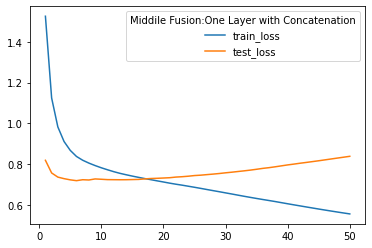

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
  
# plot lines
plt.plot(epochs, train_loss, label = "train_loss")
plt.plot(epochs, test_loss, label = "test_loss")
plt.legend(title="Middile Fusion:One Layer with Concatenation")
plt.show()

plt.plot(epochs, train_acc, label = "train_acc")
plt.plot(epochs, test_acc, label = "test_acc")
plt.legend(title="Middile Fusion:One Layer with Concatenation")
plt.show()


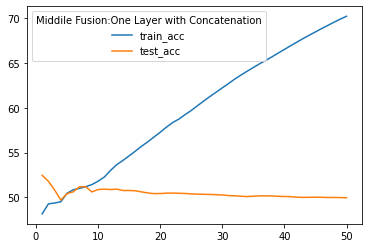

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
  
# plot lines
plt.plot(epochs, train_loss, label = "train_loss")
plt.plot(epochs, test_loss, label = "test_loss")
plt.legend(title="Middile Fusion:One Layer with Concatenation")
plt.show()

plt.plot(epochs, train_acc, label = "train_acc")
plt.plot(epochs, test_acc, label = "test_acc")
plt.legend(title="Middile Fusion:One Layer with Concatenation")
plt.show()

## Middle fusion: one layer with addition

In [ ]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) #Sparse
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=50,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, beta_1=0.99, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')

train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
test_loss_metric = tf.keras.metrics.Mean(name='test_loss')

train_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(images, questions, answers, model):
  with tf.GradientTape() as tape:
    # Forward pass
    predictions = model(images, questions)
    train_loss = loss_function(y_true=answers, y_pred=predictions)

  # Backward pass
  gradients = tape.gradient(train_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  # Record results
  train_loss_metric(train_loss)
  train_accuracy_metric(answers, predictions)

def test_step(images, questions, answers, model):
  predictions = model(images, questions)
  test_loss = loss_function(y_true=answers, y_pred=predictions)

  # Record results
  test_loss_metric(test_loss)
  test_accuracy_metric(answers, predictions)
  return predictions

@tf.function
def train_step_state(images, questions, answers, hidden ,model):
  with tf.GradientTape() as tape:
    # Forward pass
    predictions = model(images, questions, hidden)
    train_loss = loss_function(y_true=answers, y_pred=predictions)

  # Backward pass
  gradients = tape.gradient(train_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  # Record results
  train_loss_metric(train_loss)
  train_accuracy_metric(answers, predictions)

print("-------------------------------Starting model------------------------------")
model = VQAModel_onelayer_addition(len(ans_vocab), len(ques_vocab))

dataset, test_dataset, ques_vocab, ans_vocab = data
EPOCHS = 50

train_loss =[]
test_loss=[]
train_acc=[]
test_acc=[]

for epoch in range(EPOCHS):
  #init_state = model.init_state(16)
  
  for (batch, (m_name, img_tensor, question, answer)) in enumerate(dataset):

    train_step(img_tensor, question, answer[:, 1], model)

  for (batch, (name, img_tensor, question, answer)) in enumerate(test_dataset):
    test_step(img_tensor, question, answer[:, 1], model)

  template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.2f}, Test loss: {:.4f}, Test accuracy: {:.2f}'

  train_loss.append(train_loss_metric.result())
  test_loss.append(test_loss_metric.result())
  train_acc.append(train_accuracy_metric.result() * 100)
  test_acc.append(test_accuracy_metric.result() * 100)

  print(template.format(epoch +1, 
                        train_loss_metric.result(), 
                        train_accuracy_metric.result() * 100, 
                        test_loss_metric.result(), 
                        test_accuracy_metric.result() * 100))

-------------------------------Starting model------------------------------
Epoch 1, Loss: 1.0129, Accuracy: 48.82, Test loss: 1.2256, Test accuracy: 51.56
Epoch 2, Loss: 0.8888, Accuracy: 49.28, Test loss: 0.9596, Test accuracy: 52.23
Epoch 3, Loss: 0.8364, Accuracy: 49.60, Test loss: 0.8700, Test accuracy: 52.86
Epoch 4, Loss: 0.8028, Accuracy: 49.67, Test loss: 0.8270, Test accuracy: 52.12
Epoch 5, Loss: 0.7814, Accuracy: 49.70, Test loss: 0.7998, Test accuracy: 52.17
Epoch 6, Loss: 0.7670, Accuracy: 50.02, Test loss: 0.7831, Test accuracy: 51.36
Epoch 7, Loss: 0.7563, Accuracy: 50.24, Test loss: 0.7700, Test accuracy: 51.72
Epoch 8, Loss: 0.7488, Accuracy: 50.51, Test loss: 0.7610, Test accuracy: 52.05
Epoch 9, Loss: 0.7431, Accuracy: 50.50, Test loss: 0.7535, Test accuracy: 51.76
Epoch 10, Loss: 0.7378, Accuracy: 50.87, Test loss: 0.7474, Test accuracy: 51.91
Epoch 11, Loss: 0.7336, Accuracy: 51.06, Test loss: 0.7430, Test accuracy: 51.38
Epoch 12, Loss: 0.7300, Accuracy: 51.18, T

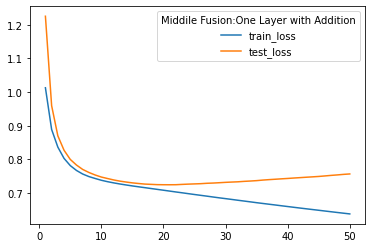

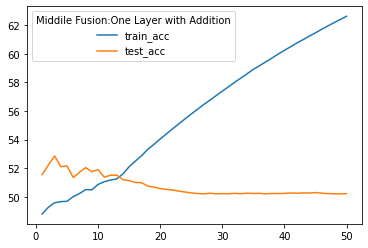

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
  
epochs = np.arange(1, 51)
# plot lines
plt.plot(epochs, train_loss, label = "train_loss")
plt.plot(epochs, test_loss, label = "test_loss")
plt.legend(title="Middile Fusion:One Layer with Addition")
plt.show()

plt.plot(epochs, train_acc, label = "train_acc")
plt.plot(epochs, test_acc, label = "test_acc")
plt.legend(title="Middile Fusion:One Layer with Addition")
plt.show()

## Middle fusion: one layer with dot_product

In [ ]:
def train_model(model, dataset, test_dataset, ques_vocab, ans_vocab):
  @tf.function
  def train_step(images, questions, answers, model):
    with tf.GradientTape() as tape:
      # Forward pass
      predictions = model(images, questions)
      train_loss = loss_function(y_true=answers, y_pred=predictions)

    # Backward pass
    gradients = tape.gradient(train_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Record results
    train_loss_metric(train_loss)
    train_accuracy_metric(answers, predictions)

  def test_step(images, questions, answers, model):
    predictions = model(images, questions)
    test_loss = loss_function(y_true=answers, y_pred=predictions)

    # Record results
    test_loss_metric(test_loss)
    test_accuracy_metric(answers, predictions)
    return predictions

  @tf.function
  def train_step_state(images, questions, answers, hidden ,model):
    with tf.GradientTape() as tape:
      # Forward pass
      predictions = model(images, questions, hidden)
      train_loss = loss_function(y_true=answers, y_pred=predictions)

    # Backward pass
    gradients = tape.gradient(train_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Record results
    train_loss_metric(train_loss)
    train_accuracy_metric(answers, predictions)

  loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) #Sparse
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=1e-3,
      decay_steps=50,
      decay_rate=0.9)

  optimizer = tf.keras.optimizers.Adam(
      learning_rate=lr_schedule, beta_1=0.99, beta_2=0.999, epsilon=1e-07, amsgrad=False,
      name='Adam')

  train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
  test_loss_metric = tf.keras.metrics.Mean(name='test_loss')

  train_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
  test_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

  
  EPOCHS = 50

  train_loss =[]
  test_loss=[]
  train_acc=[]
  test_acc=[]

  for epoch in range(EPOCHS):
    #init_state = model.init_state(16)
    
    for (batch, (m_name, img_tensor, question, answer)) in enumerate(dataset):

      train_step(img_tensor, question, answer[:, 1], model)

    for (batch, (name, img_tensor, question, answer)) in enumerate(test_dataset):
      test_step(img_tensor, question, answer[:, 1], model)

    template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.2f}, Test loss: {:.4f}, Test accuracy: {:.2f}'

    train_loss.append(train_loss_metric.result())
    test_loss.append(test_loss_metric.result())
    train_acc.append(train_accuracy_metric.result() * 100)
    test_acc.append(test_accuracy_metric.result() * 100)

    print(template.format(epoch +1, 
                          train_loss_metric.result(), 
                          train_accuracy_metric.result() * 100, 
                          test_loss_metric.result(), 
                          test_accuracy_metric.result() * 100))
    
  return train_loss, test_loss, train_acc, test_acc

def plot_results(train_loss, test_loss, train_acc, test_acc, title="Middile Fusion:One Layer with Addition"):
    epochs = np.arange(1, 51)
    # plot lines
    plt.plot(epochs, train_loss, label = "train_loss")
    plt.plot(epochs, test_loss, label = "test_loss")
    plt.legend(title=title)
    plt.show()

    plt.plot(epochs, train_acc, label = "train_acc")
    plt.plot(epochs, test_acc, label = "test_acc")
    plt.legend(title=title)
    plt.show()

In [ ]:
print("-------------------------------Starting model------------------------------")

dataset, test_dataset, ques_vocab, ans_vocab = data
model = VQAModel_onelayer_dot_product(len(ans_vocab), len(ques_vocab))

train_loss, test_loss, train_acc, test_acc = train_model(model, dataset, test_dataset, ques_vocab, ans_vocab)

-------------------------------Starting model------------------------------
Epoch 1, Loss: 0.9918, Accuracy: 51.11, Test loss: 0.7510, Test accuracy: 45.87
Epoch 2, Loss: 0.8537, Accuracy: 50.09, Test loss: 0.7331, Test accuracy: 46.15
Epoch 3, Loss: 0.8055, Accuracy: 50.18, Test loss: 0.7364, Test accuracy: 46.09
Epoch 4, Loss: 0.7809, Accuracy: 50.16, Test loss: 0.7254, Test accuracy: 47.96
Epoch 5, Loss: 0.7650, Accuracy: 50.00, Test loss: 0.7184, Test accuracy: 49.15
Epoch 6, Loss: 0.7541, Accuracy: 50.12, Test loss: 0.7142, Test accuracy: 48.74
Epoch 7, Loss: 0.7458, Accuracy: 50.00, Test loss: 0.7118, Test accuracy: 48.52
Epoch 8, Loss: 0.7398, Accuracy: 50.01, Test loss: 0.7093, Test accuracy: 49.18
Epoch 9, Loss: 0.7350, Accuracy: 50.01, Test loss: 0.7082, Test accuracy: 48.88
Epoch 10, Loss: 0.7310, Accuracy: 49.87, Test loss: 0.7065, Test accuracy: 49.38
Epoch 11, Loss: 0.7277, Accuracy: 49.95, Test loss: 0.7051, Test accuracy: 49.76
Epoch 12, Loss: 0.7248, Accuracy: 50.00, T

In [ ]:
def plot_results(train_loss, test_loss, train_acc, test_acc, title="Middile Fusion:One Layer with Addition"):
    epochs = np.arange(1, 51)
    # plot lines
    plt.plot(epochs, train_loss, label = "train_loss")
    plt.plot(epochs, test_loss, label = "test_loss")
    plt.legend(title=title)
    plt.show()

    plt.plot(epochs, train_acc, label = "train_acc")
    plt.plot(epochs, test_acc, label = "test_acc")
    plt.legend(title=title)
    plt.show()

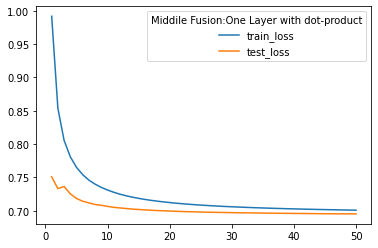

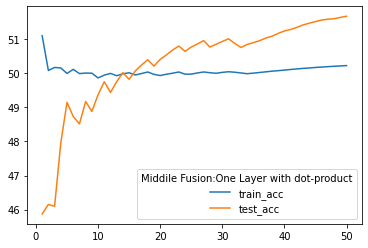

In [ ]:
plot_results(train_loss, test_loss, train_acc, test_acc, title="Middile Fusion:One Layer with dot-product")

## Middle fusion: one layer with attention

In [ ]:
print("-------------------------------Starting model------------------------------")

dataset, test_dataset, ques_vocab, ans_vocab = data
model = VQAModel_onelayer_attention(len(ans_vocab), len(ques_vocab))

train_loss, test_loss, train_acc, test_acc = train_model(model, dataset, test_dataset, ques_vocab, ans_vocab)

-------------------------------Starting model------------------------------
Epoch 1, Loss: 1.0042, Accuracy: 48.74, Test loss: 0.7603, Test accuracy: 47.21
Epoch 2, Loss: 0.8597, Accuracy: 49.26, Test loss: 0.7359, Test accuracy: 46.82
Epoch 3, Loss: 0.8081, Accuracy: 49.41, Test loss: 0.7235, Test accuracy: 49.07
Epoch 4, Loss: 0.7858, Accuracy: 49.40, Test loss: 0.7248, Test accuracy: 48.47
Epoch 5, Loss: 0.7723, Accuracy: 49.58, Test loss: 0.7255, Test accuracy: 47.86
Epoch 6, Loss: 0.7616, Accuracy: 49.56, Test loss: 0.7201, Test accuracy: 48.81
Epoch 7, Loss: 0.7526, Accuracy: 49.68, Test loss: 0.7171, Test accuracy: 49.43
Epoch 8, Loss: 0.7457, Accuracy: 49.70, Test loss: 0.7149, Test accuracy: 49.00
Epoch 9, Loss: 0.7403, Accuracy: 49.63, Test loss: 0.7122, Test accuracy: 49.53
Epoch 10, Loss: 0.7357, Accuracy: 49.62, Test loss: 0.7102, Test accuracy: 49.91
Epoch 11, Loss: 0.7318, Accuracy: 49.73, Test loss: 0.7085, Test accuracy: 50.24
Epoch 12, Loss: 0.7286, Accuracy: 49.86, T

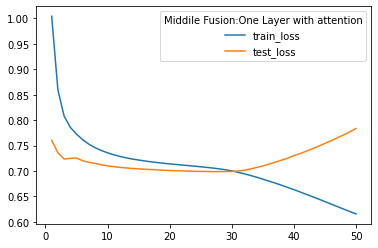

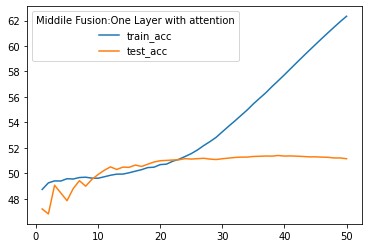

In [ ]:
plot_results(train_loss, test_loss, train_acc, test_acc, title="Middile Fusion:One Layer with attention")

In [ ]:
print("-------------------------------Starting model------------------------------")

dataset, test_dataset, ques_vocab, ans_vocab = data
model = VQAModel_onelayer_attention(len(ans_vocab), len(ques_vocab))

train_loss, test_loss, train_acc, test_acc = train_model(model, dataset, test_dataset, ques_vocab, ans_vocab)

-------------------------------Starting model------------------------------
Epoch 1, Loss: 0.8667, Accuracy: 48.14, Test loss: 0.6942, Test accuracy: 45.31
Epoch 2, Loss: 0.7801, Accuracy: 49.85, Test loss: 0.6917, Test accuracy: 49.83
Epoch 3, Loss: 0.7518, Accuracy: 50.08, Test loss: 0.6927, Test accuracy: 50.89
Epoch 4, Loss: 0.7397, Accuracy: 49.91, Test loss: 0.6963, Test accuracy: 51.56
Epoch 5, Loss: 0.7351, Accuracy: 49.57, Test loss: 0.7061, Test accuracy: 50.36
Epoch 6, Loss: 0.7309, Accuracy: 49.61, Test loss: 0.7099, Test accuracy: 49.67
Epoch 7, Loss: 0.7263, Accuracy: 49.73, Test loss: 0.7073, Test accuracy: 50.11
Epoch 8, Loss: 0.7227, Accuracy: 49.59, Test loss: 0.7053, Test accuracy: 50.53
Epoch 9, Loss: 0.7200, Accuracy: 49.65, Test loss: 0.7045, Test accuracy: 50.11
Epoch 10, Loss: 0.7175, Accuracy: 49.59, Test loss: 0.7033, Test accuracy: 50.41
Epoch 11, Loss: 0.7154, Accuracy: 49.76, Test loss: 0.7024, Test accuracy: 50.62
Epoch 12, Loss: 0.7135, Accuracy: 49.92, T

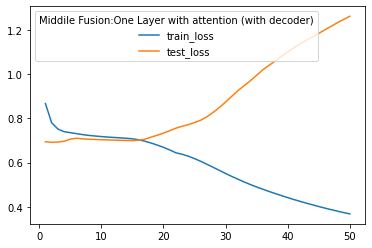

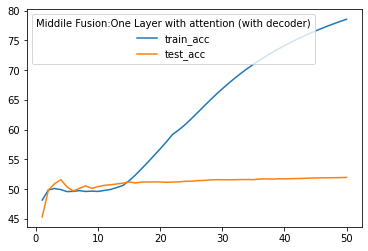

In [ ]:
plot_results(train_loss, test_loss, train_acc, test_acc, title="Middile Fusion:One Layer with attention (with decoder)")

## Middle fusion: deep fusion with addition

In [ ]:
print("-------------------------------Starting model------------------------------")

dataset, test_dataset, ques_vocab, ans_vocab = data
model = VQAModel_deep_addition(len(ans_vocab), len(ques_vocab))

train_loss, test_loss, train_acc, test_acc = train_model(model, dataset, test_dataset, ques_vocab, ans_vocab)

-------------------------------Starting model------------------------------
Epoch 1, Loss: 0.8862, Accuracy: 49.77, Test loss: 0.7319, Test accuracy: 46.54
Epoch 2, Loss: 0.7984, Accuracy: 49.62, Test loss: 0.7422, Test accuracy: 48.10
Epoch 3, Loss: 0.7847, Accuracy: 49.45, Test loss: 0.7262, Test accuracy: 49.93
Epoch 4, Loss: 0.7637, Accuracy: 49.61, Test loss: 0.7193, Test accuracy: 49.39
Epoch 5, Loss: 0.7498, Accuracy: 49.84, Test loss: 0.7141, Test accuracy: 50.20
Epoch 6, Loss: 0.7402, Accuracy: 50.07, Test loss: 0.7105, Test accuracy: 50.47
Epoch 7, Loss: 0.7332, Accuracy: 50.40, Test loss: 0.7084, Test accuracy: 50.03
Epoch 8, Loss: 0.7283, Accuracy: 50.54, Test loss: 0.7084, Test accuracy: 49.57
Epoch 9, Loss: 0.7240, Accuracy: 50.77, Test loss: 0.7088, Test accuracy: 49.12
Epoch 10, Loss: 0.7199, Accuracy: 51.15, Test loss: 0.7079, Test accuracy: 49.05
Epoch 11, Loss: 0.7162, Accuracy: 51.67, Test loss: 0.7078, Test accuracy: 49.18
Epoch 12, Loss: 0.7129, Accuracy: 52.10, T

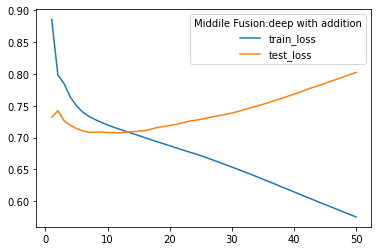

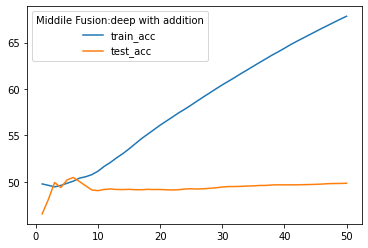

In [ ]:
plot_results(train_loss, test_loss, train_acc, test_acc, title="Middile Fusion:deep with addition")

## Middle fusion: deep fusion with dot-product

In [ ]:
print("-------------------------------Starting model------------------------------")

dataset, test_dataset, ques_vocab, ans_vocab = data
model = VQAModel_deep_dot_product(len(ans_vocab), len(ques_vocab))

train_loss, test_loss, train_acc, test_acc = train_model(model, dataset, test_dataset, ques_vocab, ans_vocab)

-------------------------------Starting model------------------------------
Epoch 1, Loss: 1.6105, Accuracy: 49.19, Test loss: 1.5739, Test accuracy: 46.43
Epoch 2, Loss: 1.5713, Accuracy: 49.23, Test loss: 1.5416, Test accuracy: 46.76
Epoch 3, Loss: 1.5388, Accuracy: 49.19, Test loss: 1.5131, Test accuracy: 46.69
Epoch 4, Loss: 1.5092, Accuracy: 49.24, Test loss: 1.4869, Test accuracy: 46.57
Epoch 5, Loss: 1.4822, Accuracy: 49.26, Test loss: 1.4623, Test accuracy: 46.54
Epoch 6, Loss: 1.4575, Accuracy: 49.25, Test loss: 1.4393, Test accuracy: 46.58
Epoch 7, Loss: 1.4347, Accuracy: 49.25, Test loss: 1.4182, Test accuracy: 46.52
Epoch 8, Loss: 1.4135, Accuracy: 49.26, Test loss: 1.3983, Test accuracy: 46.58
Epoch 9, Loss: 1.3938, Accuracy: 49.26, Test loss: 1.3801, Test accuracy: 46.56
Epoch 10, Loss: 1.3756, Accuracy: 49.26, Test loss: 1.3632, Test accuracy: 46.53
Epoch 11, Loss: 1.3587, Accuracy: 49.26, Test loss: 1.3473, Test accuracy: 46.55
Epoch 12, Loss: 1.3429, Accuracy: 49.26, T

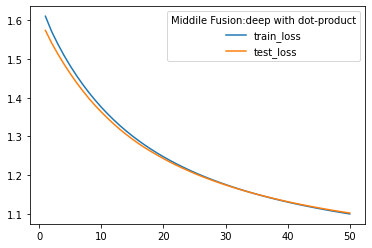

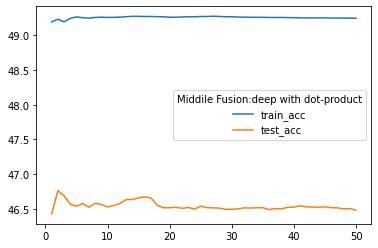

In [ ]:
plot_results(train_loss, test_loss, train_acc, test_acc, title="Middile Fusion:deep with dot-product")

## Middle fusion: deep fusion with attention

In [ ]:
print("-------------------------------Starting model------------------------------")

dataset, test_dataset, ques_vocab, ans_vocab = data
model = VQAModel_deep_with_attention(len(ans_vocab), len(ques_vocab))

train_loss, test_loss, train_acc, test_acc = train_model(model, dataset, test_dataset, ques_vocab, ans_vocab)

-------------------------------Starting model------------------------------
Epoch 1, Loss: 1.0761, Accuracy: 48.79, Test loss: 0.6917, Test accuracy: 52.68
Epoch 2, Loss: 0.8902, Accuracy: 48.71, Test loss: 0.6918, Test accuracy: 53.01
Epoch 3, Loss: 0.8270, Accuracy: 49.20, Test loss: 0.6923, Test accuracy: 53.53
Epoch 4, Loss: 0.7951, Accuracy: 49.62, Test loss: 0.6921, Test accuracy: 53.71
Epoch 5, Loss: 0.7762, Accuracy: 49.77, Test loss: 0.6948, Test accuracy: 52.17
Epoch 6, Loss: 0.7630, Accuracy: 49.96, Test loss: 0.6954, Test accuracy: 51.06
Epoch 7, Loss: 0.7535, Accuracy: 50.15, Test loss: 0.6957, Test accuracy: 51.37
Epoch 8, Loss: 0.7465, Accuracy: 50.29, Test loss: 0.6969, Test accuracy: 50.75
Epoch 9, Loss: 0.7409, Accuracy: 50.28, Test loss: 0.6960, Test accuracy: 51.22
Epoch 10, Loss: 0.7368, Accuracy: 50.12, Test loss: 0.6963, Test accuracy: 50.79
Epoch 11, Loss: 0.7330, Accuracy: 50.18, Test loss: 0.6959, Test accuracy: 51.03
Epoch 12, Loss: 0.7298, Accuracy: 50.27, T

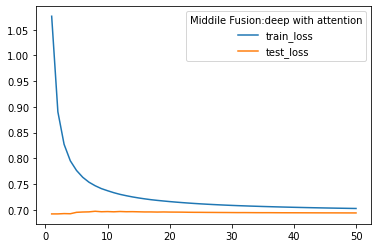

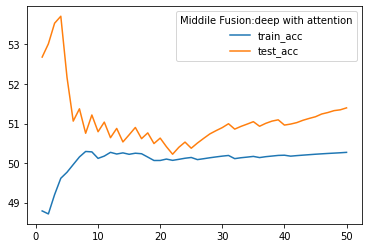

In [ ]:
plot_results(train_loss, test_loss, train_acc, test_acc, title="Middile Fusion:deep with attention")

## Middle fusion: short-cut fusion with addition

In [47]:
print("-------------------------------Starting model------------------------------")

dataset, test_dataset, ques_vocab, ans_vocab = data
model = VQAModel_shortcut_addition(len(ans_vocab), len(ques_vocab))

train_loss, test_loss, train_acc, test_acc = train_model(model, dataset, test_dataset, ques_vocab, ans_vocab)

-------------------------------Starting model------------------------------
Epoch 1, Loss: 1.3224, Accuracy: 49.67, Test loss: 0.6954, Test accuracy: 53.35
Epoch 2, Loss: 1.0115, Accuracy: 50.35, Test loss: 0.6956, Test accuracy: 49.72
Epoch 3, Loss: 0.9056, Accuracy: 50.81, Test loss: 0.6986, Test accuracy: 48.44
Epoch 4, Loss: 0.8522, Accuracy: 51.24, Test loss: 0.6987, Test accuracy: 48.02
Epoch 5, Loss: 0.8189, Accuracy: 51.98, Test loss: 0.6991, Test accuracy: 47.72
Epoch 6, Loss: 0.7952, Accuracy: 53.07, Test loss: 0.6999, Test accuracy: 47.81
Epoch 7, Loss: 0.7769, Accuracy: 54.03, Test loss: 0.7020, Test accuracy: 48.04
Epoch 8, Loss: 0.7624, Accuracy: 54.80, Test loss: 0.7057, Test accuracy: 48.12
Epoch 9, Loss: 0.7501, Accuracy: 55.70, Test loss: 0.7087, Test accuracy: 48.24
Epoch 10, Loss: 0.7392, Accuracy: 56.51, Test loss: 0.7126, Test accuracy: 48.34
Epoch 11, Loss: 0.7296, Accuracy: 57.21, Test loss: 0.7158, Test accuracy: 48.55
Epoch 12, Loss: 0.7201, Accuracy: 57.96, T

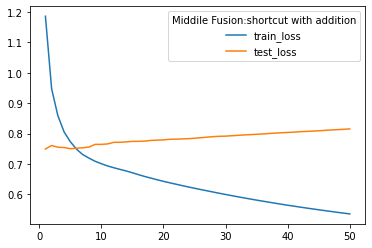

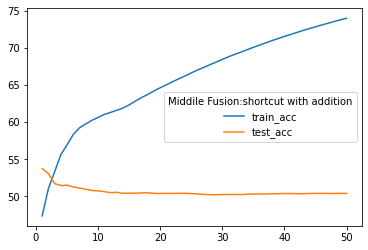

In [ ]:
plot_results(train_loss, test_loss, train_acc, test_acc, title="Middile Fusion:shortcut with addition")

## Middle fusion: short-cut fusion with concatenation

In [ ]:
for (batch, (m_name, img_tensor, question, answer)) in enumerate(test_dataset):
    print(batch)

    # for (batch, (name, img_tensor, question, answer)) in enumerate(test_dataset):
    #   test_step(img_tensor, question, answer[:, 1], model)

0
1
2
3
4
5
6


In [ ]:
print("-------------------------------Starting model------------------------------")

dataset, test_dataset, ques_vocab, ans_vocab = data
model = VQAModel_shortcut_concatenation(len(ans_vocab), len(ques_vocab))

train_loss, test_loss, train_acc, test_acc = train_model(model, dataset, test_dataset, ques_vocab, ans_vocab)

-------------------------------Starting model------------------------------
Epoch 1, Loss: 1.2218, Accuracy: 50.18, Test loss: 0.8978, Test accuracy: 53.91
Epoch 2, Loss: 1.0050, Accuracy: 50.64, Test loss: 0.8368, Test accuracy: 54.24
Epoch 3, Loss: 0.9067, Accuracy: 52.01, Test loss: 0.8116, Test accuracy: 53.31
Epoch 4, Loss: 0.8486, Accuracy: 53.73, Test loss: 0.7883, Test accuracy: 52.34
Epoch 5, Loss: 0.8100, Accuracy: 55.18, Test loss: 0.7747, Test accuracy: 51.85
Epoch 6, Loss: 0.7828, Accuracy: 56.46, Test loss: 0.7686, Test accuracy: 51.43
Epoch 7, Loss: 0.7622, Accuracy: 57.41, Test loss: 0.7636, Test accuracy: 51.21
Epoch 8, Loss: 0.7473, Accuracy: 58.09, Test loss: 0.7594, Test accuracy: 51.02
Epoch 9, Loss: 0.7343, Accuracy: 58.74, Test loss: 0.7599, Test accuracy: 50.89
Epoch 10, Loss: 0.7237, Accuracy: 59.38, Test loss: 0.7577, Test accuracy: 50.87
Epoch 11, Loss: 0.7144, Accuracy: 59.87, Test loss: 0.7570, Test accuracy: 50.69
Epoch 12, Loss: 0.7060, Accuracy: 60.39, T

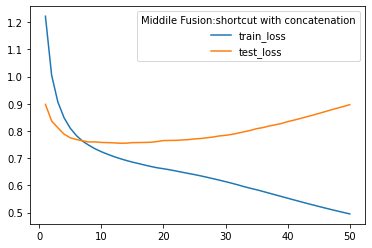

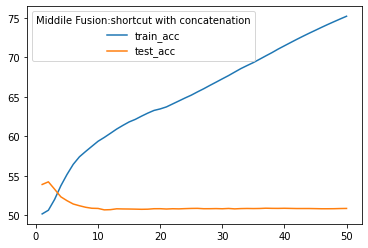

In [ ]:
plot_results(train_loss, test_loss, train_acc, test_acc, title="Middile Fusion:shortcut with concatenation")

## Middle fusion: short-cut fusion with dot-product


In [ ]:
print("-------------------------------Starting model------------------------------")

dataset, test_dataset, ques_vocab, ans_vocab = data
model = VQAModel_shortcut_dotproduct(len(ans_vocab), len(ques_vocab))

train_loss, test_loss, train_acc, test_acc = train_model(model, dataset, test_dataset, ques_vocab, ans_vocab)

-------------------------------Starting model------------------------------
Epoch 1, Loss: 1.2657, Accuracy: 48.11, Test loss: 0.7409, Test accuracy: 51.79
Epoch 2, Loss: 0.9820, Accuracy: 52.13, Test loss: 0.7331, Test accuracy: 50.45
Epoch 3, Loss: 0.8793, Accuracy: 54.05, Test loss: 0.7419, Test accuracy: 49.67
Epoch 4, Loss: 0.8246, Accuracy: 55.54, Test loss: 0.7389, Test accuracy: 49.97
Epoch 5, Loss: 0.7916, Accuracy: 56.66, Test loss: 0.7476, Test accuracy: 50.63
Epoch 6, Loss: 0.7790, Accuracy: 56.49, Test loss: 0.7452, Test accuracy: 50.54
Epoch 7, Loss: 0.7691, Accuracy: 56.56, Test loss: 0.7437, Test accuracy: 50.77
Epoch 8, Loss: 0.7592, Accuracy: 56.64, Test loss: 0.7526, Test accuracy: 50.67
Epoch 9, Loss: 0.7483, Accuracy: 57.08, Test loss: 0.7513, Test accuracy: 50.52
Epoch 10, Loss: 0.7371, Accuracy: 57.68, Test loss: 0.7516, Test accuracy: 50.56
Epoch 11, Loss: 0.7266, Accuracy: 58.34, Test loss: 0.7508, Test accuracy: 50.64
Epoch 12, Loss: 0.7172, Accuracy: 58.92, T

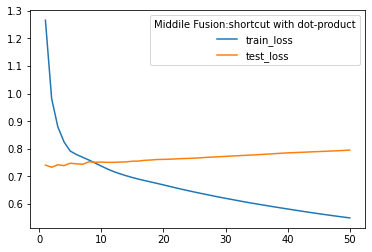

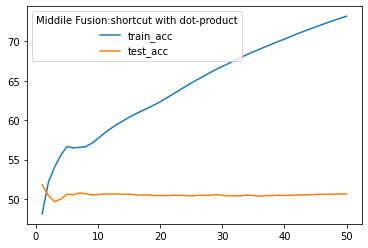

In [ ]:
plot_results(train_loss, test_loss, train_acc, test_acc, title="Middile Fusion:shortcut with dot-product")

## Middle fusion: short-cut fusion with attention


In [44]:
print("-------------------------------Starting model------------------------------")

dataset, test_dataset, ques_vocab, ans_vocab = data
model = VQAModel_shortcut_with_attention(len(ans_vocab), len(ques_vocab))

train_loss, test_loss, train_acc, test_acc = train_model(model, dataset, test_dataset, ques_vocab, ans_vocab)

-------------------------------Starting model------------------------------
Epoch 1, Loss: 5.9592, Accuracy: 48.34, Test loss: 1.2226, Test accuracy: 48.55
Epoch 2, Loss: 3.6869, Accuracy: 50.15, Test loss: 1.7358, Test accuracy: 47.66
Epoch 3, Loss: 2.8580, Accuracy: 51.33, Test loss: 1.4862, Test accuracy: 48.03
Epoch 4, Loss: 2.3590, Accuracy: 52.87, Test loss: 1.3407, Test accuracy: 48.21
Epoch 5, Loss: 2.0347, Accuracy: 54.39, Test loss: 1.2582, Test accuracy: 48.33
Epoch 6, Loss: 1.8064, Accuracy: 55.89, Test loss: 1.1938, Test accuracy: 48.42
Epoch 7, Loss: 1.6383, Accuracy: 57.20, Test loss: 1.1454, Test accuracy: 48.53
Epoch 8, Loss: 1.5096, Accuracy: 58.28, Test loss: 1.1048, Test accuracy: 48.79
Epoch 9, Loss: 1.4099, Accuracy: 59.20, Test loss: 1.0729, Test accuracy: 48.91
Epoch 10, Loss: 1.3295, Accuracy: 59.92, Test loss: 1.0528, Test accuracy: 49.12
Epoch 11, Loss: 1.2651, Accuracy: 60.41, Test loss: 1.0308, Test accuracy: 49.23
Epoch 12, Loss: 1.2113, Accuracy: 60.81, T

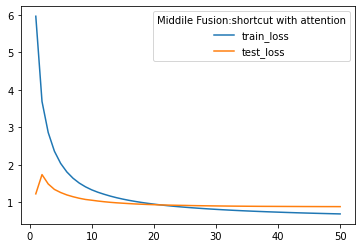

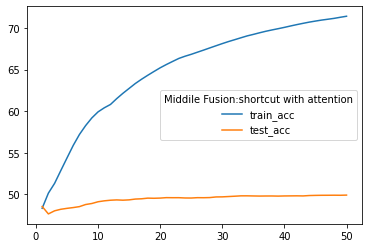

In [45]:
plot_results(train_loss, test_loss, train_acc, test_acc, title="Middile Fusion:shortcut with attention")